## Навигация: <a class="anchor" id="content_list"></a>
* [Линейная регрессия (LinearRegression)](#linreg)
* [Регуляризация (снижение дисперсии модели)](#regul)
* [Логистическая регрессия (LogRegression)](#logreg)
* [K ближайших соседей (KNN)](#knn)
* [Деревья решений (DecisionTree)](#dectree)

* [В конец блокнота](#end)

# Линейная регрессия (LinearRegression) <a class="anchor" id="linreg"></a>
[к меню](#content_list)

**Линейная регрессия (англ. Linear regression)** — используемая в статистике регрессионная модель зависимости одной (объясняемой, зависимой) переменной **y** от другой или нескольких других переменных (факторов, регрессоров, независимых переменных) **x** с линейной функцией зависимости

$$\widehat{y} = \widehat{\beta_{0}} + \widehat{\beta_{1}}x_{1} + \widehat{\beta_{2}}x_{2} + \epsilon$$

<img src=https://media.proglib.io/wp-uploads/2019/04/fig-lin-reg.jpg width=800 height=600>

Итак мы стремимся минимизировать сумму квадратов ошибок, которые допускает наша модель линейной регрессии
$$
e = y - \widehat{y} = Residuals
$$
$$
\sum e_j^2 \rightarrow min
$$

Расмотрим пример решения линейной регрессии на примере набора данных "Стоимости Бостонских домов"

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_boston
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
boston = load_boston()
features = boston.data
target = boston.target
features_name = boston.feature_names

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

Создадим и обучим модель линейной регрессии на всех признаках

In [ ]:
lr = LinearRegression()
lr.fit(features, target)
lr.score(features, target)

0.7406426641094095

In [ ]:
print(f"Параметр b0: {lr.intercept_}")
print(f"Значениея остальных параметров бетта:")
coef_dict = {feature:coef for feature, coef in zip(features_name, lr.coef_)}
for item in coef_dict.items():
    print(*item)

Параметр b0: 36.459488385090125
Значениея остальных параметров бетта:
CRIM -0.10801135783679545
ZN 0.04642045836688176
INDUS 0.02055862636707862
CHAS 2.6867338193448966
NOX -17.766611228300167
RM 3.809865206809212
AGE 0.0006922246403425021
DIS -1.475566845600255
RAD 0.30604947898517226
TAX -0.01233459391657437
PTRATIO -0.9527472317072923
B 0.009311683273793711
LSTAT -0.5247583778554923


In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2 # для выбора категориальных входных признаков
from sklearn.feature_selection import f_regression # числовые признаки и числовой выходной признак
from sklearn.feature_selection import f_classif # числовые входные признаки и категориальный выходной признак
bestfeatures = SelectKBest(score_func=f_regression, k=10)
fit = bestfeatures.fit(features, target)
best_feature_num = fit.scores_.argmax()
print(f"Номер лучшего признака {best_feature_num} - это признак {features_name[best_feature_num]}")

Номер лучшего признака 12 - это признак LSTAT


In [ ]:
best_feature = features[:, best_feature_num].reshape(-1,1)
lr_one = LinearRegression()
lr_one.fit(best_feature, target)
lr_one.score(best_feature, target)

0.5441462975864797

In [ ]:
print(f"y = {lr_one.intercept_} + {lr_one.coef_[0]}x")

y = 34.5538408793831 + -0.9500493537579906x


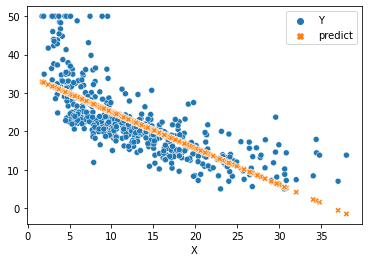

In [ ]:
frame_to_snack = (best_feature.ravel(), target, lr_one.predict(best_feature))
df = pd.DataFrame(np.vstack(frame_to_snack).T, columns=['X', "Y", "predict"])
df = df.set_index("X")
sns.scatterplot(data=df)

## Некоторые примеры работы с линейной регрессией

**Сделаем вариант регрессионной модели на минимальном пригодном наборе признаков**

In [ ]:
'''рекурсивное удаление признаков. Значимость признаков расчитывается на основе перекрестной проверки'''
from sklearn.feature_selection import RFECV
mini_lr = LinearRegression()
rfe = RFECV(estimator=mini_lr, step=1, cv=5, scoring='r2')
rfe.fit(features, target)
print("Optimal number of features : %d" % rfe.n_features_)

rfe_support = rfe.get_support()
check_feature = features[:, rfe_support]
mini_lr.fit(check_feature, target)
mini_lr.score(check_feature, target)

Optimal number of features : 6


0.7157742117396082

In [ ]:
from sklearn.model_selection import KFold, cross_val_score
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cross_val_score(LinearRegression(), X=check_feature, y=target, cv=kf, scoring="r2").mean()

0.7001464368381212

### Моделирование взаимодействия признаков

Иногда влияние признака на целевую переменную по крайней мере частично зависит от другого признака. Например, представьте себе простой пример с кофе, где у нас два бинарных признака — наличие сахара (sugar) и было ли выполнено перемешивание (stirred) — и требуется предсказать, сладкий ли кофе на вкус. Просто положив сахар в кофе (sugar=1, stirred=0), мы не сделаем вкус кофе сладким (весь сахар на дне!), а одно перемешивание кофе без добавления сахара (sugar=0, stirred=i) не сделает его сладким. Как раз наоборот, именно взаимодействие брошенного в кофе сахара и перемешивания кофе (sugar=1, stirred=1) сделает вкус кофе сладким. Влияния сахара и перемешивания на сладость зависят друг от друга. В этом случае мы говорим, что существует эффект взаимодействия между призна
ками sugar И stirred.
$$\widehat{y} = \widehat{\beta_{0}} + \widehat{\beta_{1}}x_{1} + \widehat{\beta_{2}}x_{2}+ \widehat{\beta_{3}}x_{1}x_{2} + \epsilon$$

**Попробуем воссоздать такой эффект взаимодействия между признаками**

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import  StandardScaler
from sklearn.pipeline import make_pipeline
interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
features_interaction = interaction.fit_transform(check_feature)
features_interaction.shape

(506, 41)

In [ ]:
interaction.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x5',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x0 x5',
 'x1 x2',
 'x1 x3',
 'x1 x4',
 'x1 x5',
 'x2 x3',
 'x2 x4',
 'x2 x5',
 'x3 x4',
 'x3 x5',
 'x4 x5',
 'x0 x1 x2',
 'x0 x1 x3',
 'x0 x1 x4',
 'x0 x1 x5',
 'x0 x2 x3',
 'x0 x2 x4',
 'x0 x2 x5',
 'x0 x3 x4',
 'x0 x3 x5',
 'x0 x4 x5',
 'x1 x2 x3',
 'x1 x2 x4',
 'x1 x2 x5',
 'x1 x3 x4',
 'x1 x3 x5',
 'x1 x4 x5',
 'x2 x3 x4',
 'x2 x3 x5',
 'x2 x4 x5',
 'x3 x4 x5']

In [ ]:
interaction_lr = LinearRegression()
interaction_lr.fit(features_interaction, target)
interaction_lr.score(features_interaction, target)

0.8740745791681933

In [ ]:
cross_val_score(LinearRegression(), X=features_interaction, y=target, cv=kf, scoring="r2").mean()

0.8224615193159707

**Попробуем нормализовать данные перед обучением**

In [ ]:
pipe = make_pipeline(StandardScaler(), interaction, LinearRegression())
pipe.fit(check_feature, target)
pipe.score(check_feature, target)

0.8740745791681933

In [ ]:
cross_val_score(pipe, X=check_feature, y=target, cv=kf, scoring="r2").mean()

0.8224615193159888

## Моделируем эффект нелинейности

- До сих пор мы обсуждали моделирование только линейных связей. Примером линейной связи может служить количество этажей здания и его высота. В линейной регрессии мы исходим из того, что эффект количества этажей и высоты здания примерно постоянен, а это означает, что 20-этажное здание будет примерно в два раза выше, чем 10-этажное, которое будет примерно в два раза выше, чем 5-этажное здание.
- Однако многие представляющие интерес связи не являются строго линейными. Нередко требуется смоделировать нелинейную связь — например, связь между количеством часов, которые учащийся тратит на учебу, и оценкой, которую он получает за контрольную работу. Интуитивно мы можем себе представить, что в оценках между учащимися, которые учились в течение одного часа, и учащимися, которые вообще не учились, есть большая разница. Вместе с тем существует гораздо меньшая разница в оценках между учащимся, который учился в течение 99 часов, и учащимся, который учился в течение 100 часов. Влияние одного часа учебы на итоговую оценку учащегося уменьшается по мере увеличения количества часов.
- Полиномиальная регрессия — это расширение линейной регрессии, позволяющее моделировать нелинейные связи. Для того чтобы создать полиномиальную регрессию, следует конвертировать линейную функцию
$$\widehat{y} = \widehat{\beta_{0}} + \widehat{\beta_{1}}x_{1} + \widehat{\beta_{2}}x_1^2 + ... + \epsilon$$

In [ ]:
non_linear = PolynomialFeatures(degree=3, include_bias=False, interaction_only=False)
features_non_linear = non_linear.fit_transform(check_feature)
features_non_linear.shape

(506, 83)

In [ ]:
non_linear.get_feature_names()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['x0',
 'x1',
 'x2',
 'x3',
 'x4',
 'x5',
 'x0^2',
 'x0 x1',
 'x0 x2',
 'x0 x3',
 'x0 x4',
 'x0 x5',
 'x1^2',
 'x1 x2',
 'x1 x3',
 'x1 x4',
 'x1 x5',
 'x2^2',
 'x2 x3',
 'x2 x4',
 'x2 x5',
 'x3^2',
 'x3 x4',
 'x3 x5',
 'x4^2',
 'x4 x5',
 'x5^2',
 'x0^3',
 'x0^2 x1',
 'x0^2 x2',
 'x0^2 x3',
 'x0^2 x4',
 'x0^2 x5',
 'x0 x1^2',
 'x0 x1 x2',
 'x0 x1 x3',
 'x0 x1 x4',
 'x0 x1 x5',
 'x0 x2^2',
 'x0 x2 x3',
 'x0 x2 x4',
 'x0 x2 x5',
 'x0 x3^2',
 'x0 x3 x4',
 'x0 x3 x5',
 'x0 x4^2',
 'x0 x4 x5',
 'x0 x5^2',
 'x1^3',
 'x1^2 x2',
 'x1^2 x3',
 'x1^2 x4',
 'x1^2 x5',
 'x1 x2^2',
 'x1 x2 x3',
 'x1 x2 x4',
 'x1 x2 x5',
 'x1 x3^2',
 'x1 x3 x4',
 'x1 x3 x5',
 'x1 x4^2',
 'x1 x4 x5',
 'x1 x5^2',
 'x2^3',
 'x2^2 x3',
 'x2^2 x4',
 'x2^2 x5',
 'x2 x3^2',
 'x2 x3 x4',
 'x2 x3 x5',
 'x2 x4^2',
 'x2 x4 x5',
 'x2 x5^2',
 'x3^3',
 'x3^2 x4',
 'x3^2 x5',
 'x3 x4^2',
 'x3 x4 x5',
 'x3 x5^2',
 'x4^3',
 'x4^2 x5',
 'x4 x5^2',
 'x5^3']

In [ ]:
non_linear_lr = LinearRegression()
non_linear_lr.fit(features_non_linear, target)
non_linear_lr.score(features_non_linear, target)

0.9034175313778191

In [ ]:
cross_val_score(LinearRegression(), X=features_non_linear, y=target, cv=kf, scoring="r2").mean()

0.561373763123685

## Регуляризация (снижение дисперсии модели) <a class="anchor" id="regul"></a>
[к меню](#content_list)

В стандартной линейной регрессии модель тренируется минимизировать сумму квадратической ошибки (погрешности) между истинными **у**, и предсказываемыми $$\widehat{y}$$, целевыми значениями, или остаточную сумму квадратов (residual sum of squares, RSS):
$$RSS = \sum_{i=1}^n(y_{i} - \widehat{y_{i}})^{2}$$
Регуляризованные регрессионные ученики похожи, за исключением того, что они пытаются минимизировать RSS и некий штраф за общий размер значений коэффициентов, называемый сжимающим штрафом, потому что он пытается "сжать" модель. Существуют два распространенных типа регуляризованных учеников для линейной регрессии: гребневая регрессия и лассо. Единственным формальным различием между ними является тип применяемого сжимающего штрафа. 
В гребневой регрессии сжимающий штраф — это настроечный гиперпараметр, умноженный на квадрат суммы всех коэффициентов:
$$RSS + \alpha\sum_{j=1}^p\beta_j^2$$
$$\beta_j$$  - коэффициент  j-го  из  p  признака
$$\alpha$$ - гиперпараметр

Лассо-регрессия очень похожа на гребневую регрессию, за исключением того, что сжимающий штраф — это настроечный параметр, умножаемый на сумму абсолютных значений всех коэффициентов:
$$\frac{1}{2n}RSS + \alpha\sum_{j=1}^p|\beta_j|$$
где n - количество наблюдений
Так какой же из них следует использовать? В качестве очень общего эмпирического правила нужно учитывать, что гребневая perрессия часто дает несколько лучшие предсказания, чем лассо, но лассо производит более интерпретируемые модели. Если мы хотим сбалансировать штрафные функции между гребнем и лассо, мы можем использовать эластичную сеть, представляющую собой регрессионную модель, в которую включены оба штрафа. Независимо от того, какой из них мы используем, гребневая регрессия и лассо-регрессия могут штрафовать большие или
сложные модели, включая значения коэффициентов в функцию потери, которую мы пытаемся минимизировать.
Гиперпараметр **а** позволяет нам контролировать то, насколько мы штрафуем коэффициенты, где более высокие значения а создают более простые модели. Идеальное значение а должно быть настроено, как и любой другой гиперпараметр. В библиотеке scikit-leam а устанавливается с помощью параметра alpha.
Библиотека scikit-leam включает класс Ridgecv, реализующий метод, который позволяет отбирать идеальное значение для **а**

#### Гребневая регрессия

In [ ]:
from sklearn.linear_model import Ridge
mini_lr = LinearRegression()
mini_lr.fit(check_feature, target)
cross_val_score(LinearRegression(), X=check_feature, y=target, cv=kf, scoring="r2").mean()

0.7001464368381214

In [ ]:
print(*mini_lr.coef_.round(5))

3.2443 -18.74043 4.11181 -1.14459 -1.00275 -0.56984


In [ ]:
for alpha in [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 100.0]:
    mini_r = Ridge(alpha=alpha)
    mini_r.fit(check_feature, target)
    score = cross_val_score(Ridge(alpha=alpha), X=check_feature, y=target, cv=kf, scoring="r2").mean()
    print(f"alpha = {alpha}, score = {score}")
    print(*mini_r.coef_.round(5))

alpha = 0.0, score = 0.7001464368381214
3.2443 -18.74043 4.11181 -1.14459 -1.00275 -0.56984
alpha = 0.1, score = 0.700147890674226
3.22107 -17.96782 4.11206 -1.11795 -1.00006 -0.57368
alpha = 0.5, score = 0.6994340900432752
3.13879 -15.42302 4.11103 -1.0304 -0.99138 -0.58645
alpha = 1.0, score = 0.6979639404826818
3.05305 -13.10134 4.10661 -0.95086 -0.98373 -0.59834
alpha = 5.0, score = 0.6898731973726254
2.62034 -5.9295 4.0313 -0.71068 -0.96458 -0.63935
alpha = 10.0, score = 0.6860583218658289
2.2819 -3.51012 3.91903 -0.63637 -0.96367 -0.65906
alpha = 100.0, score = 0.6675650927325139
0.74921 -0.40419 2.55668 -0.58498 -1.00014 -0.75969


In [ ]:
standarter = StandardScaler()
standart_feature = standarter.fit_transform(check_feature)
for alpha in [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 100.0]:
    mini_r = Ridge(alpha=alpha)
    mini_r.fit(standart_feature, target)
    score = cross_val_score(Ridge(alpha=alpha), X=standart_feature, y=target, cv=kf, scoring="r2").mean()
    print(f"alpha = {alpha}, score = {score}")
    print(*mini_r.coef_.round(5))

alpha = 0.0, score = 0.7001464368381216
0.82322 -2.16945 2.88617 -2.40778 -2.16874 -4.06527
alpha = 0.1, score = 0.7001540572653415
0.82321 -2.16794 2.88632 -2.40563 -2.1684 -4.06433
alpha = 0.5, score = 0.7001834727257931
0.82318 -2.16195 2.88689 -2.39706 -2.16704 -4.06056
alpha = 1.0, score = 0.7002178794213083
0.82314 -2.15452 2.88758 -2.38642 -2.16535 -4.05587
alpha = 5.0, score = 0.7004052618809269
0.82276 -2.09766 2.89244 -2.30421 -2.15214 -4.01889
alpha = 10.0, score = 0.7004477361232528
0.82213 -2.03241 2.89695 -2.2082 -2.13644 -3.97404
alpha = 100.0, score = 0.6865119008085454
0.79229 -1.42446 2.82037 -1.18642 -1.93305 -3.36388


In [ ]:
from sklearn.linear_model import RidgeCV
regr_cv = RidgeCV(alphas=[0.1, 0.3, 0.5, 1.0, 5.0, 10.0, 15.0, 20.0])
regr_cv.fit(standart_feature, target)
print(f"alpha = {regr_cv.alpha_}, score = {regr_cv.score(standart_feature, target)}")
print(*regr_cv.coef_.round(5))

alpha = 10.0, score = 0.7155119002063273
0.82213 -2.03241 2.89695 -2.2082 -2.13644 -3.97404


**Протестим на всех фичах набора**

In [ ]:
regr_cv = RidgeCV(alphas=[0.1, 0.3, 0.5, 1.0, 5.0, 10.0, 15.0, 20.0])
regr_cv.fit(features, target)
print(f"alpha = {regr_cv.alpha_}, score = {regr_cv.score(features, target)}")
print(*regr_cv.coef_.round(5))

alpha = 0.1, score = 0.7406002922228019
-0.10747 0.04657 0.016 2.67002 -16.68465 3.81823 -0.00027 -1.45963 0.30352 -0.01242 -0.94076 0.00937 -0.52597


In [ ]:
regr_cv = RidgeCV(alphas=[0.1, 0.3, 0.5, 1.0, 5.0, 10.0, 15.0, 20.0])
regr_cv.fit(features_interaction, target)
print(f"alpha = {regr_cv.alpha_}, score = {regr_cv.score(features_interaction, target)}")
print(*regr_cv.coef_.round(5))

alpha = 0.1, score = 0.8694849598846984
-4.94879 -5.32364 40.45002 5.42347 3.62199 14.18323 -3.95176 -4.59995 -6.49511 6.86748 -2.99478 -7.78759 -7.65305 11.19182 -7.0944 -1.99839 -0.93979 -2.43728 0.20383 -0.3633 -0.31795 -0.66925 -0.25728 -3.08982 3.14414 2.04771 -0.15682 -0.06471 -0.89154 0.51576 -0.01253 2.67205 -1.16856 1.4296 -1.00956 0.56136 -0.2017 0.0567 0.02325 0.06226 -0.00025


In [ ]:
regr_cv = RidgeCV(alphas=[0.1, 0.3, 0.5, 1.0, 5.0, 10.0, 15.0, 20.0])
regr_cv.fit(features_non_linear, target)
print(f"alpha = {regr_cv.alpha_}, score = {regr_cv.score(features_non_linear, target)}")
print(*regr_cv.coef_.round(5))

alpha = 20.0, score = 0.8909450254166452
0.03067 0.00657 0.12566 -0.12412 -0.03026 0.0465 0.03067 -0.00955 0.18117 0.00689 0.29096 0.03701 0.0222 0.05084 -0.06903 0.02828 0.05322 0.92912 -0.32336 0.98918 -0.38307 0.3934 -0.98654 0.71393 0.23719 -0.38837 0.27384 0.03067 -0.00955 0.18117 0.00689 0.29096 0.03701 -0.03262 -0.10389 -0.0502 -0.44868 -0.20031 0.52237 0.32113 -0.76354 0.21413 0.30682 -0.30849 0.03323 0.22722 -0.11941 0.01642 0.03491 0.10234 0.01265 0.29775 0.41952 -0.57159 -0.17367 -0.12969 0.21016 0.10105 -0.36822 0.85785 0.06849 -0.08803 -0.10935 0.0903 -0.02854 -0.09491 -0.01264 -0.08636 0.17492 -0.11321 -0.04812 0.04685 -0.00913 -0.01885 0.04742 -0.02978 -0.01607 0.02416 -0.02007 0.00045 0.00102 -0.00191 -0.00064


Посмотрим какие фичи наиболее сильно вляют на скорость изменения таргета

In [ ]:
np.array(non_linear.get_feature_names())[np.abs(regr_cv.coef_) > 0.1]

array(['x2', 'x3', 'x0 x2', 'x0 x4', 'x2^2', 'x2 x3', 'x2 x4', 'x2 x5',
       'x3^2', 'x3 x4', 'x3 x5', 'x4^2', 'x4 x5', 'x5^2', 'x0^2 x2',
       'x0^2 x4', 'x0 x1 x2', 'x0 x1 x4', 'x0 x1 x5', 'x0 x2^2',
       'x0 x2 x3', 'x0 x2 x4', 'x0 x2 x5', 'x0 x3^2', 'x0 x3 x4',
       'x0 x4^2', 'x0 x4 x5', 'x1^2 x2', 'x1^2 x4', 'x1^2 x5', 'x1 x2^2',
       'x1 x2 x3', 'x1 x2 x4', 'x1 x2 x5', 'x1 x3^2', 'x1 x3 x4',
       'x1 x3 x5', 'x1 x5^2', 'x2 x3 x4', 'x2 x3 x5'], dtype='<U8')

#### Лассо-регрессия

In [ ]:
from sklearn.linear_model import Lasso, LassoCV
import warnings
warnings.filterwarnings('ignore')
mini_lr = LinearRegression()
mini_lr.fit(check_feature, target)
cross_val_score(LinearRegression(), X=check_feature, y=target, cv=kf, scoring="r2").mean()

0.7001464368381214

In [ ]:
print(*mini_lr.coef_.round(5))

3.2443 -18.74043 4.11181 -1.14459 -1.00275 -0.56984


In [ ]:
for alpha in [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 100.0]:
    mini_r = Lasso(alpha=alpha)
    mini_r.fit(check_feature, target)
    score = cross_val_score(Lasso(alpha=alpha), X=check_feature, y=target, cv=kf, scoring="r2").mean()
    print(f"alpha = {alpha}, score = {score}")
    print(*mini_r.coef_.round(5))

alpha = 0.0, score = 0.7001464368381215
3.2443 -18.74043 4.11181 -1.14459 -1.00275 -0.56984
alpha = 0.1, score = 0.6783656407063642
1.39066 -0.0 3.91357 -0.50124 -0.94452 -0.67541
alpha = 0.5, score = 0.6662640959043922
0.0 -0.0 2.77666 -0.44084 -0.9264 -0.73209
alpha = 1.0, score = 0.6381732275531616
0.0 -0.0 1.32934 -0.32984 -0.87911 -0.79877
alpha = 5.0, score = 0.5303242813236302
0.0 -0.0 0.0 -0.0 -0.04342 -0.84688
alpha = 10.0, score = 0.5098485977500239
0.0 -0.0 0.0 -0.0 -0.0 -0.75356
alpha = 100.0, score = -0.011227733238148695
0.0 -0.0 0.0 0.0 -0.0 -0.0


In [ ]:
for alpha in [0.0, 0.1, 0.5, 1.0, 5.0, 10.0, 100.0]:
    mini_r = Lasso(alpha=alpha)
    mini_r.fit(standart_feature, target)
    score = cross_val_score(Lasso(alpha=alpha), X=standart_feature, y=target, cv=kf, scoring="r2").mean()
    print(f"alpha = {alpha}, score = {score}")
    print(*mini_r.coef_.round(5))

alpha = 0.0, score = 0.7001464368381216
0.82322 -2.16945 2.88617 -2.40778 -2.16874 -4.06527
alpha = 0.1, score = 0.6989166836088051
0.74509 -1.7553 2.88455 -1.95449 -2.06528 -4.02861
alpha = 0.5, score = 0.6685965817309315
0.4326 -0.09787 2.8791 -0.1399 -1.65172 -3.881
alpha = 1.0, score = 0.6471545282882543
0.00532 -0.0 2.6821 -0.0 -1.35597 -3.62388
alpha = 5.0, score = 0.25715928019583
0.0 -0.0 0.47794 0.0 -0.0 -1.48429
alpha = 10.0, score = -0.011227733238148695
0.0 -0.0 0.0 0.0 -0.0 -0.0
alpha = 100.0, score = -0.011227733238148695
0.0 -0.0 0.0 0.0 -0.0 -0.0


In [ ]:
lasr_cv = LassoCV(alphas=[0.1, 0.3, 0.5, 1.0, 5.0, 10.0, 15.0, 20.0])
lasr_cv.fit(standart_feature, target)
print(f"alpha = {lasr_cv.alpha_}, score = {lasr_cv.score(standart_feature, target)}")
print(*lasr_cv.coef_.round(5))

alpha = 0.1, score = 0.7144866090582158
0.74509 -1.7553 2.88455 -1.95449 -2.06528 -4.02861


**Протестим на всех фичах набора**

In [ ]:
lasr_cv = LassoCV(alphas=[0.1, 0.3, 0.5, 1.0, 5.0, 10.0, 15.0, 20.0])
lasr_cv.fit(features, target)
print(f"alpha = {lasr_cv.alpha_}, score = {lasr_cv.score(features, target)}")
print(*lasr_cv.coef_.round(5))

alpha = 0.3, score = 0.7206350048380019
-0.09146 0.04974 -0.01783 0.0 -0.0 3.09583 -0.00096 -1.04048 0.28051 -0.01528 -0.772 0.00991 -0.61682


In [ ]:
lasr_cv = LassoCV(alphas=[0.1, 0.3, 0.5, 1.0, 5.0, 10.0, 15.0, 20.0])
lasr_cv.fit(features_interaction, target)
print(f"alpha = {lasr_cv.alpha_}, score = {lasr_cv.score(features_interaction, target)}")
print(*lasr_cv.coef_.round(5))

alpha = 1.0, score = 0.7722462777163666
0.0 -0.0 0.0 0.0 -0.0 -0.0 -0.0 0.0 -0.0 0.0 -0.0 0.0 -0.0 -0.0 -0.0 0.0 0.0046 0.0 -0.65909 0.0 0.00184 -0.0 -0.0 0.0 -0.0 -0.0 0.0393 -0.06332 -0.0 -0.0 0.01102 0.0 0.0 -0.0 -0.31969 -0.0 -0.00639 0.10528 -0.03501 -0.01009 0.01999


In [ ]:
lasr_cv = LassoCV(alphas=[0.1, 0.3, 0.5, 1.0, 5.0, 10.0, 15.0, 20.0])
lasr_cv.fit(features_non_linear, target)
print(f"alpha = {lasr_cv.alpha_}, score = {lasr_cv.score(features_non_linear, target)}")
print(*lasr_cv.coef_.round(5))

alpha = 1.0, score = 0.851371070709806
0.0 -0.0 0.0 -0.0 0.0 0.0 0.0 -0.0 -0.0 0.0 0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 0.0 -0.0 0.0 0.0 -0.0 -0.20021 -0.0 0.06361 0.0 0.00031 0.0 -0.0 -0.0 0.0 0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 0.0 -0.11056 -0.0 0.0 0.0 -0.0 0.05236 -0.01006 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.0 -0.06046 -0.0 0.08659 0.02868 -0.00915 -0.02638 -0.00554 0.00274 -0.0 -0.01279 0.00231 0.00666 -0.01121 0.02804 -0.02373 -0.01006 0.01981 -0.00372 0.00274 -0.00344 0.00054 -0.00012


In [ ]:
lasr_cv.intercept_

22.581761340082718

Посмотрим какие фичи дают нам весь результат

In [ ]:
np.array(non_linear.get_feature_names())[np.abs(lasr_cv.coef_) > 0.0001]

array(['x3 x4', 'x4^2', 'x5^2', 'x0 x2 x4', 'x0 x4^2', 'x0 x4 x5',
       'x1 x4 x5', 'x2^3', 'x2^2 x3', 'x2^2 x4', 'x2^2 x5', 'x2 x3^2',
       'x2 x3 x4', 'x2 x4^2', 'x2 x4 x5', 'x2 x5^2', 'x3^3', 'x3^2 x4',
       'x3^2 x5', 'x3 x4^2', 'x3 x4 x5', 'x3 x5^2', 'x4^3', 'x4^2 x5',
       'x4 x5^2', 'x5^3'], dtype='<U8')

# Логистическая регрессия (LogRegression) <a class="anchor" id="logreg"></a>
[к меню](#content_list)

Несмотря на наличие слова "регрессия" в названии, логистическая регрессия на самом деле является широко используемым бинарным классификатором (т. е. вектор целей может принимать только два значения). В логистической регрессии линейная модель (например, b0 + b1*х) включается в логистическую (так называемую сигмоидальную) функцию:
$$\frac{1}{1 + e^{-x}}$$

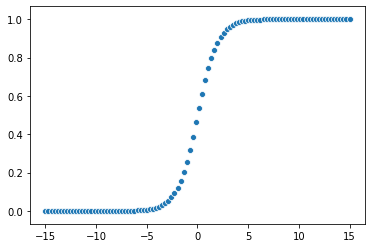

In [ ]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))
x = np.linspace(-15, 15, 100)
y = sigmoid(x)
sns.scatterplot(x,y)

таким образом, что:
$$P(y_i = 1|X) = \frac{1}{1 + e^{-(\beta_0 + \beta_1x)}}$$
где
- Р(уi: 1|X ) — вероятность, что целевое значение i-го наблюдения **у**, является классом 1;
- X — тренировочные данные; 
- b0 и b1 — параметры, которые необходимо заучить;
- е — эйлерово число.
Эффект логистической функции заключается в ограничении значения результата функции диапазоном между 0 и 1, чтобы его можно было интерпретировать как вероятность. Если Р(yi = 1|X) больше 0.5, то предсказывается класс 1, в противном случае — класс 0.
В библиотеке scikit-leam можно заучить логистическую регрессионную модель с
помощью класса LogisticRegression. После тренировки модели ее можно использо вать для предсказания класса новых наблюдений

**Посмотрим влияние коэффициентов линейной регресии на вывод логистической регрессии**

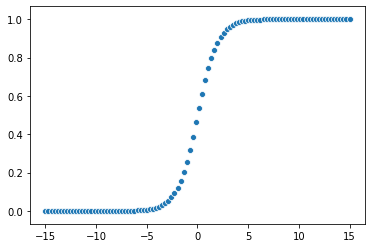

In [ ]:
def linreg(x, b0=5, b1=0.5):
    return b0 + b1 * x
x = np.linspace(-15, 15, 100)
y = sigmoid(linreg(x, 0, 1))
sns.scatterplot(x,y)

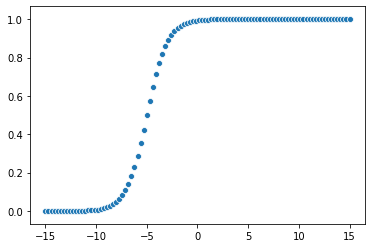

In [ ]:
x = np.linspace(-15, 15, 100)
y = sigmoid(linreg(x, 5, 1))
sns.scatterplot(x,y)

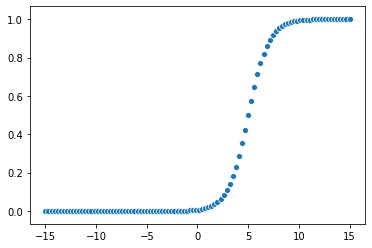

In [ ]:
x = np.linspace(-15, 15, 100)
y = sigmoid(linreg(x, -5, 1))
sns.scatterplot(x,y)

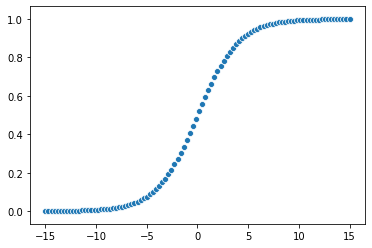

In [ ]:
x = np.linspace(-15, 15, 100)
y = sigmoid(linreg(x, 0, 0.5))
sns.scatterplot(x,y)

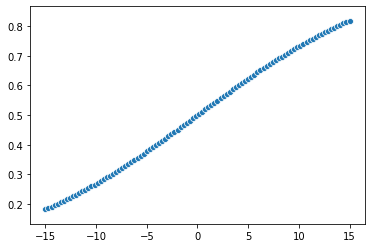

In [ ]:
x = np.linspace(-15, 15, 100)
y = sigmoid(linreg(x, 0, 0.1))
sns.scatterplot(x,y)

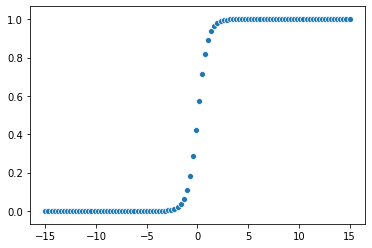

In [ ]:
x = np.linspace(-15, 15, 100)
y = sigmoid(linreg(x, 0, 2.0))
sns.scatterplot(x,y)

Бинарный вариант классификации

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Binarizer, KBinsDiscretizer
from sklearn.metrics import accuracy_score, f1_score, classification_report
threshold = (target.max() - target.min())/2
target_2 = Binarizer(threshold=threshold).fit_transform(target.reshape(-1, 1))
scaler = StandardScaler()
features_standardized = scaler.fit_transform(features)

In [ ]:
log_reg = LogisticRegression(random_state=0)
log_reg.fit(features, target_2)
cross_val_score(LogisticRegression(), X=features, y=target_2, cv=kf, scoring="f1_weighted").mean()

0.8675274341859227

In [ ]:
log_reg.intercept_, log_reg.coef_

(array([0.11816061]),
 array([[-0.19396836,  0.01736957, -0.01593396,  0.12884098,  0.04522009,
          1.22268873, -0.01260113, -0.51186528,  0.10117537, -0.00220449,
         -0.18426862,  0.00466572, -0.30319192]]))

In [ ]:
log_reg = LogisticRegression(random_state=0)
log_reg.fit(features_standardized, target_2)
cross_val_score(LogisticRegression(), X=features_standardized, y=target_2, cv=kf, scoring="f1_weighted").mean()

0.8833933357448682

In [ ]:
log_reg.intercept_, log_reg.coef_

(array([-0.89608154]),
 array([[-0.24821129,  0.15132036, -0.26635355,  0.14079354, -0.29311517,
          0.75062883, -0.5622411 , -1.02424762,  1.32913275, -0.77324194,
         -0.87895372,  0.12414996, -2.26013251]]))

**Вариант мультиклассовой классификации "один против всех"**

Сами по себе логистические регрессии являются исключительно бинарными классификаторами, т. е. они не могут обрабатывать векторы целей с более чем двумя классами. Однако два умных расширения логистической регрессии делают именно это. Во-первых, в логистической регрессии по методу "один против остальных" (one-vs-rest, OVR) для каждого класса тренируется отдельная модель, предсказывающая, является ли наблюдение этим классом или нет (что делает его задачей бинарной классификации). Такой классификатор исходит из того, что каждая классификационная задача (например, класс 0 или нет) является независимой.

In [ ]:
target_3 = KBinsDiscretizer(n_bins=3, encode='ordinal').fit_transform(target.reshape(-1,1))
log_reg = LogisticRegression(random_state=0, multi_class="ovr")
log_reg.fit(features, target_3)
cross_val_score(LogisticRegression(multi_class="ovr"), X=features, y=target_3, cv=kf, scoring="f1_weighted").mean()

0.7395964483841334

In [ ]:
log_reg = LogisticRegression(random_state=0, multi_class="ovr")
log_reg.fit(features_standardized, target_3)
cross_val_score(LogisticRegression(random_state=0, multi_class="ovr"), X=features_standardized, y=target_3, cv=kf, scoring="f1_weighted").mean()

0.7643405616908211

**Вариант мультиклассовой классификации "мультикласс"**

В качестве альтернативы в полиномиальной логистической регрессии (multinomial logistic regression, MLR) логистическая функция, которую мы разобрали ранее, заменяется функцией softmax (многопеременной логистической функцией):
$$P(y_i = k|X) = \frac{e^{\beta_kx_i}}{\sum_{j=1}^Ke^{\beta_jx_i}}$$
где Р(уi = к|Х) — вероятность, что целевое значение i-го наблюдения **у**, является классом **k**, **К** — общее количество классов. Одним из практических преимуществ MLR является то, что его предсказанные вероятности с использованием метода predict proba более надежны (т. е. лучше откалиброваны).
При использовании класса LogisticRegression можно выбрать один из двух методов по своему усмотрению, при этом метод OVR, ovr, указывается в аргументе multi class по умолчанию. Мы можем переключиться на метод MNL, присвоив этому аргументу значение **multinomial**

In [ ]:
log_reg = LogisticRegression(random_state=0, multi_class="multinomial")
log_reg.fit(features, target_3)
cross_val_score(LogisticRegression(random_state=0, multi_class="multinomial"), X=features, y=target_3, cv=kf, scoring="f1_weighted").mean()

0.7335528821345907

In [ ]:
log_reg = LogisticRegression(random_state=0, multi_class="multinomial")
log_reg.fit(features_standardized, target_3)
cross_val_score(LogisticRegression(random_state=0, multi_class="multinomial"), X=features_standardized, y=target_3, cv=kf, scoring="f1_weighted").mean()

0.7678611723043762

**Регуляризация**
Регуляризация — это метод штрафования сложных моделей с целью уменьшения их дисперсии. В частности, штрафной член добавляется в функцию потери, которую мы пытаемся минимизировать, как правило, это штрафы L1 и L2:
- L1 штраф
$$\alpha\sum_{j=1}^p|\beta_j|$$
- L2 штраф
$$\alpha\sum_{j=1}^p\beta_j^2$$
Более высокие значения **а** увеличивают штраф за более крупные значения параметров (т. е. более сложные модели). Библиотека scikit-leam следует общему методу использования обозначения **С** вместо **а** , где **С** — это обратная величина силы регуляризации: **С = 1/а**.
Для того чтобы уменьшить дисперсию при использовании логистической регрессии, мы можем рассматривать **С** как гиперпараметр, который нужно настроить, чтобы найти значение **С**, создающее наилучшую модель. В библиотеке scikit-leam можно использовать класс LogisticRegressionCV для эффективной настройки **С**. Параметр **Cs** класса LogisticRegressionCV может либо принимать диапазон значений **С** для поиска (если в качестве аргумента указан список вещественных чисел), либо, если задано целое число, сгенерирует список из заданного
количества потенциальных значений, полученных из логарифмической шкалы
между -10 000 и 10 000.
К сожалению, класс LogisticRegressionCV не позволяет производить поиск по различным штрафным членам

In [ ]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2)
standart_feature = StandardScaler().fit_transform(features)
best_feature_2 = model.fit_transform(standart_feature)
best_feature_2.shape

(506, 2)

In [ ]:
indexes_for_draw = np.random.choice(target_2.shape[0], 250)
target_2_ = target_2[indexes_for_draw]
best_feature_2_ = best_feature_2[indexes_for_draw]

In [ ]:
log_reg_1 = LogisticRegression(random_state=0,
                             C=1.0,
                             penalty="l2",
                             solver="saga")
log_reg_1.fit(standart_feature, target_2)
predict_1 = log_reg_1.predict(standart_feature)
cross_val_score(log_reg_1,
                X=standart_feature, 
                y=target_2, 
                cv=kf, 
                scoring="f1_weighted").mean()

0.8833933357448682

In [ ]:
log_reg_0_1 = LogisticRegression(random_state=0,
                             C=0.001,
                             penalty="l2",
                             solver="saga")
log_reg_0_1.fit(standart_feature, target_2)
predict_0_1 = log_reg_0_1.predict(standart_feature)
cross_val_score(log_reg_0_1,
                X=standart_feature, 
                y=target_2, 
                cv=kf, 
                scoring="f1_weighted").mean()

0.7502647310008645

In [ ]:
log_reg_10 = LogisticRegression(random_state=0,
                             C=1000.0,
                             penalty="l2",
                             solver="saga")
log_reg_10.fit(standart_feature, target_2)
predict_10 = log_reg_10.predict(standart_feature)
cross_val_score(log_reg_10,
                X=standart_feature, 
                y=target_2, 
                cv=kf, 
                scoring="f1_weighted").mean()

0.8774009257878383

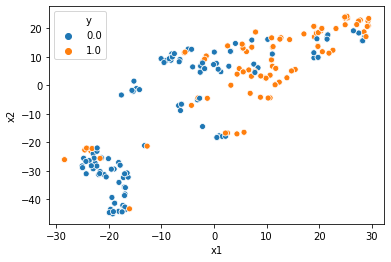

In [ ]:
df = pd.DataFrame(np.hstack((best_feature_2_, target_2_.reshape(-1,1))),
                 columns=["x1", "x2", "y"])
sns.scatterplot(data=df, x="x1", y="x2", hue="y")

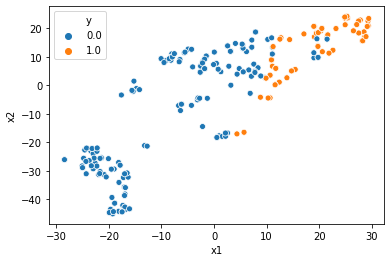

In [ ]:
df = pd.DataFrame(np.hstack((best_feature_2_, predict_0_1[indexes_for_draw].reshape(-1,1))),
                 columns=["x1", "x2", "y"])
sns.scatterplot(data=df, x="x1", y="x2", hue="y")

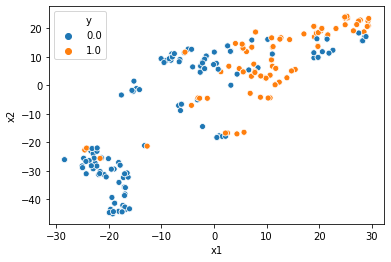

In [ ]:
df = pd.DataFrame(np.hstack((best_feature_2_, predict_1[indexes_for_draw].reshape(-1,1))),
                 columns=["x1", "x2", "y"])
sns.scatterplot(data=df, x="x1", y="x2", hue="y")

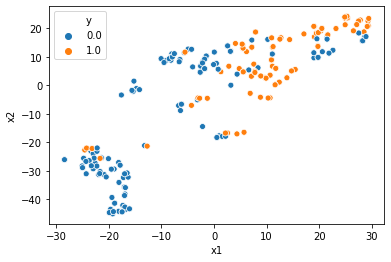

In [ ]:
df = pd.DataFrame(np.hstack((best_feature_2_, predict_10[indexes_for_draw].reshape(-1,1))),
                 columns=["x1", "x2", "y"])
sns.scatterplot(data=df, x="x1", y="x2", hue="y")

Эксперименты на бинарной классификации

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
# ‘l1’, ‘l2’, ‘elasticnet’, ‘none’
logregcv = LogisticRegressionCV(random_state=0, penalty="l2")
logregcv.fit(features_standardized, target_2)
cross_val_score(
    LogisticRegressionCV(random_state=0, 
                         penalty="l2"),
    X=features_standardized, y=target_2,
    cv=kf, scoring="f1_weighted").mean()

0.8671497779448784

In [ ]:
logregcv = LogisticRegressionCV(random_state=0, penalty="l1", solver='saga')
logregcv.fit(features_standardized, target_2)
cross_val_score(
    LogisticRegressionCV(random_state=0, 
                         penalty="l1",
                         solver='saga'),
    X=features_standardized, y=target_2,
    cv=kf, scoring="f1_weighted").mean()

0.8711985948357437

In [ ]:
logregcv = LogisticRegressionCV(random_state=0, penalty="elasticnet",
                                solver='saga',
                                l1_ratios=[0, 0.1, 0.3, 0.5, 0.7, 1.0])
logregcv.fit(features_standardized, target_2)
cross_val_score(
    LogisticRegressionCV(random_state=0, 
                         penalty="elasticnet",
                         solver='saga',
                         l1_ratios=[0, 0.1, 0.3, 0.5, 0.7, 1.0]),
    X=features_standardized, y=target_2,
    cv=kf, scoring="f1_weighted").mean()

0.8650811988958329

Эксперименты на мульти классификации

In [ ]:
from sklearn.linear_model import LogisticRegressionCV
# ‘l1’, ‘l2’, ‘elasticnet’, ‘none’
logregcv = LogisticRegressionCV(random_state=0, penalty="l2")
logregcv.fit(features_standardized, target_3)
cross_val_score(
    LogisticRegressionCV(random_state=0, 
                         penalty="l2"),
    X=features_standardized, y=target_3,
    cv=kf, scoring="f1_weighted").mean()

0.7737288490288161

In [ ]:
logregcv = LogisticRegressionCV(random_state=0, penalty="l1", solver='saga')
logregcv.fit(features_standardized, target_3)
cross_val_score(
    LogisticRegressionCV(random_state=0, 
                         penalty="l1",
                         solver='saga'),
    X=features_standardized, y=target_3,
    cv=kf, scoring="f1_weighted").mean()

0.7776225904817359

In [ ]:
logregcv = LogisticRegressionCV(random_state=0, penalty="elasticnet",
                                solver='saga',
                                l1_ratios=[0, 0.1, 0.3, 0.5, 0.7, 1.0])
logregcv.fit(features_standardized, target_3)
cross_val_score(
    LogisticRegressionCV(random_state=0, 
                         penalty="elasticnet",
                         solver='saga',
                         l1_ratios=[0, 0.1, 0.3, 0.5, 0.7, 1.0]),
    X=features_standardized, y=target_3,
    cv=kf, scoring="f1_weighted").mean()

0.7653743445536305

In [ ]:
logregcv.coef_

array([[ 1.00061559, -0.47332432, -0.33235463, -0.21370624,  1.23514188,
        -0.39178201,  0.77386624,  1.43638128, -1.85279271,  1.1349    ,
         0.91766326, -0.32196316,  1.98715668],
       [-1.04567488,  0.18045619,  0.27026521,  0.06882706, -0.38056742,
        -0.45849039, -0.2285498 , -0.3462692 ,  0.1056273 ,  0.18202218,
        -0.13278014,  0.4969082 , -0.03658928],
       [ 0.04505929,  0.29286813,  0.06208942,  0.14487918, -0.85457446,
         0.8502724 , -0.54531645, -1.09011208,  1.74716541, -1.31692218,
        -0.78488312, -0.17494504, -1.9505674 ]])

In [ ]:
from sklearn.linear_model import RidgeClassifierCV, LassoCV, ElasticNetCV
r_cv_clf = RidgeClassifierCV(cv=kf,
                             alphas=[0.1, 0.3, 0.5, 1.0, 5.0, 10.0, 20.0])
l_cv_clf = LassoCV(cv=kf,
                    alphas=[0.1, 0.3, 0.5, 1.0, 5.0, 10.0, 20.0])
el_cv_clf = ElasticNetCV(cv=kf,
                          alphas=[0.1, 0.3, 0.5, 1.0, 5.0, 10.0, 20.0],
                         )
cross_val_score(
    r_cv_clf,
    X=features_standardized, y=target_3,
    cv=kf, scoring="f1_weighted").mean()

0.7267189238703755

In [ ]:
cross_val_score(
    l_cv_clf,
    X=features_standardized, y=target_3,
    cv=kf).mean()

0.585654354083862

In [ ]:
cross_val_score(
    el_cv_clf,
    X=features_standardized, y=target_3,
    cv=kf).mean()

0.6092021047376752

# K ближайших соседей (KNN) <a class="anchor" id="knn"></a>
[к меню](#content_list)

Метод ближайших соседей (k Nearest Neighbors, или kNN) — тоже очень популярный метод классификации, также иногда используемый в задачах регрессии. Это, наравне с деревом решений, один из самых понятных подходов к классификации. На уровне интуиции суть метода такова: посмотри на соседей, какие преобладают, таков и ты. Формально основой метода является гипотеза компактности: если метрика расстояния между примерами введена достаточно удачно, то схожие примеры гораздо чаще лежат в одном классе, чем в разных.

Согласно методу ближайших соседей, тестовый пример (зеленый шарик) будет отнесен к классу "синие", а не "красные".
<img src=https://hsto.org/files/4b8/000/4ab/4b80004ab2414944802677e2e1cb1b76.png>

Например, если не знаешь, какой тип товара указать в объявлении для Bluetooth-гарнитуры, можешь найти 5 похожих гарнитур, и если 4 из них отнесены к категории "Аксессуары", и только один — к категории "Техника", то здравый смысл подскажет для своего объявления тоже указать категорию "Аксессуары".
Для классификации каждого из объектов тестовой выборки необходимо последовательно выполнить следующие операции:
- Вычислить расстояние до каждого из объектов обучающей выборки
- Отобрать **k** объектов обучающей выборки, расстояние до которых минимально
- Класс классифицируемого объекта — это класс, наиболее часто встречающийся среди **k** ближайших соседей

Под задачу **регрессии** метод адаптируется довольно легко – на **3** шаге возвращается **не метка**, а **число – среднее (или медианное) значение целевого признака среди соседей.**
Примечательное свойство такого подхода – его **ленивость**. Это значит, что вычисления начинаются только в момент классификации тестового примера, а заранее, только при наличии обучающих примеров, никакая модель не строится. В этом отличие, например, от логистической регрессии, где сначала на основе обучающей выборки находятся коэффициенты уравнения, а потом относительно быстро происходит классификация тестовых примеров. 

Качество классификации/регрессии методом ближайших соседей зависит от нескольких параметров:
- число соседей
- метрика расстояния между объектами (часто используются метрика Хэмминга, евклидово расстояние, косинусное расстояние и расстояние Минковского). Отметим, что при использовании большинства метрик значения признаков надо масштабировать. Условно говоря, чтобы признак "Зарплата" с диапазоном значений до 100 тысяч не вносил больший вклад в расстояние, чем "Возраст" со значениями до 100.
- веса соседей (соседи тестового примера могут входить с разными весами, например, чем дальше пример, тем с меньшим коэффициентом учитывается его "голос")

Основные параметры класса sklearn.neighbors.KNeighborsClassifier:
- weights: "uniform" (все веса равны), "distance" (вес обратно пропорционален расстоянию до тестового примера) или другая определенная пользователем функция
- algorithm (опционально): "brute", "ball_tree", "KD_tree", или "auto". В первом случае ближайшие соседи для каждого тестового примера считаются перебором обучающей выборки. Во втором и третьем — расстояние между примерами хранятся в дереве, что ускоряет нахождение ближайших соседей. В случае указания параметра "auto" подходящий способ нахождения соседей будет выбран автоматически на основе обучающей выборки.
- metric: "minkowski", "manhattan", "euclidean", "chebyshev" и другие

Метрики:
- $$d_{евклидово} = \sqrt{\sum_{i=1}^n(x_{i} - y_{i})^2}$$
- $$d_{манхэттенское} = \sum_{i=1}^n|x_{i} - y_{i}|$$
- $$d_{Минковского} = (\sum_{i=1}^n|x_{i} - y_{i}|^p)^{1/p}$$
- Косинусный коэффициент. Может применяться между двумя вещественными векторами и и принимать значение в диапазоне от –1 (абсолютная противоположность) до 1 (абсолютное совпадение) с промежуточным значением 0, говорящим об отсутствии зависимости. Вспомните определение:
$$(\overrightarrow{x},\overrightarrow{y}) = \frac{\overrightarrow{x}\cdot\overrightarrow{y}}{||\overrightarrow{x}|| ||\overrightarrow{y}||}$$
- Расстояние Жаккара, или подобие. Это уравнение вычисляет расстояние между наборами объектов, например списком друзей Кэти — A = {Kahn, Mark, Laura...} и Рэйчел — B = {Mladen, Kahn, Mark...}, и говорит, насколько близки эти два набора:
$$J(A,B) = \frac{|A\cap B|}{|A\cup B|}$$
- Расстояние Хемминга. Может служить для поиска расстояния между двумя строками либо парами слов или последовательностями ДНК одинаковой длины. Расстояние между словами olive и ocean равно 4, так как все буквы, за исключением «o», отличаются. Расстояние между словами shoe и hose равно 3, поскольку все буквы, кроме «e», отличаются. Вы выполняете проход по всем позициям для сличения букв, и если в проходимой позиции они отличаются, то увеличиваете получившееся значение на 1
- Другие меры расстояния смотрите: https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.DistanceMetric.html#sklearn.neighbors.DistanceMetric

In [ ]:
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.datasets import load_boston

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import  StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Binarizer, KBinsDiscretizer

from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2 # для выбора категориальных входных признаков
from sklearn.feature_selection import f_regression # числовые признаки и числовой выходной признак
from sklearn.feature_selection import f_classif # числовые входные признаки и категориальный выходной признак

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
"""Грузим данные"""
boston = load_boston()
features = boston.data
target = boston.target
features_name = boston.feature_names
"""Делаем стандартизированные признаки"""
scaler = StandardScaler()
features_standardized = scaler.fit_transform(features)
"""Создаем таргет для бинарной классификации"""
threshold = (target.max() - target.min())/2
target_2 = Binarizer(threshold=threshold).fit_transform(target.reshape(-1, 1)).flatten()
"""Создаем таргет для мультиклассификации"""
target_3 = KBinsDiscretizer(n_bins=3, encode='ordinal').fit_transform(target.reshape(-1,1)).flatten()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [ ]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

## Решаем задачу регрессии

**Решение "влоб"**

In [ ]:
knn_r = KNeighborsRegressor()
model = knn_r.fit(features, target)
cross_val_score(knn_r, X=features, y=target, cv=kf, scoring="r2").mean()

0.5383871944766712

**Стандартизируем признаки**

In [ ]:
knn_r = KNeighborsRegressor()
model = knn_r.fit(features_standardized, target)
cross_val_score(knn_r, X=features_standardized, y=target, cv=kf, scoring="r2").mean()

0.7467630955402731

**Отбираем значимые признаки и используем для обучения**

In [ ]:
mini_lr = LinearRegression()
rfe = RFECV(estimator=mini_lr, step=1, cv=5, scoring='r2')
rfe.fit(features, target)
print("Optimal number of features : %d" % rfe.n_features_)

rfe_support = rfe.get_support()
check_feature = features[:, rfe_support]
mini_knn = KNeighborsRegressor()
model = mini_knn.fit(check_feature, target)
cross_val_score(mini_knn, X=check_feature, y=target, cv=kf, scoring="r2").mean()

Optimal number of features : 6


0.7593465949886958

**Отбираем лучшие признаки из стандартизированных**

In [ ]:
mini_lr = LinearRegression()
rfe = RFECV(estimator=mini_lr, step=1, cv=5, scoring='r2')
rfe.fit(features_standardized, target)
print("Optimal number of features : %d" % rfe.n_features_)

rfe_support = rfe.get_support()
check_feature = features_standardized[:, rfe_support]
mini_knn = KNeighborsRegressor()
model = mini_knn.fit(check_feature, target)
cross_val_score(mini_knn, X=check_feature, y=target, cv=kf, scoring="r2").mean()

Optimal number of features : 11


0.7650402748985357

**Ранее мы обсудили, что есть несколько параметров значимых для ближайших соседей. Давайте посмотрим, как они влияют**

**Учитываем только количество соседей, на основе, которых принимаем решение**

CPU times: user 169 ms, sys: 9.15 ms, total: 178 ms
Wall time: 194 ms


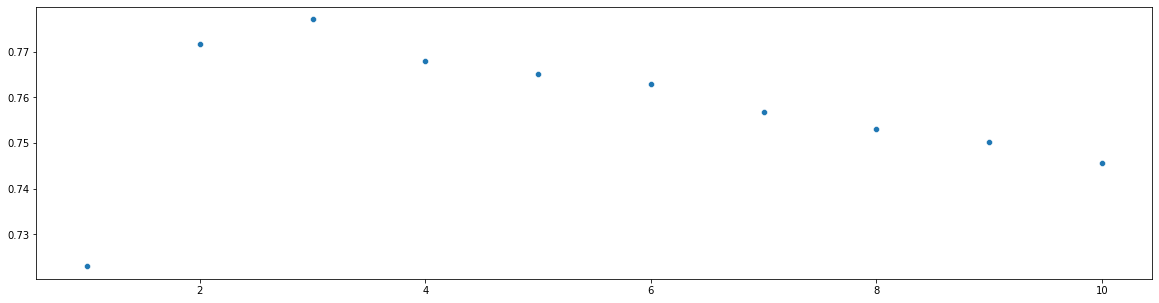

In [ ]:
%%time
plt.figure(figsize=(20, 5))
x, y = [], []
for n_neighbors in range(1,11):
    x.append(n_neighbors)
    knn_r = KNeighborsRegressor(n_neighbors=n_neighbors)
    y.append(cross_val_score(knn_r, X=check_feature, y=target, cv=kf, scoring="r2").mean())
sns.scatterplot(x=x, y=y)

**Учитываем только размерность метрики Минковского**

CPU times: user 661 ms, sys: 0 ns, total: 661 ms
Wall time: 665 ms


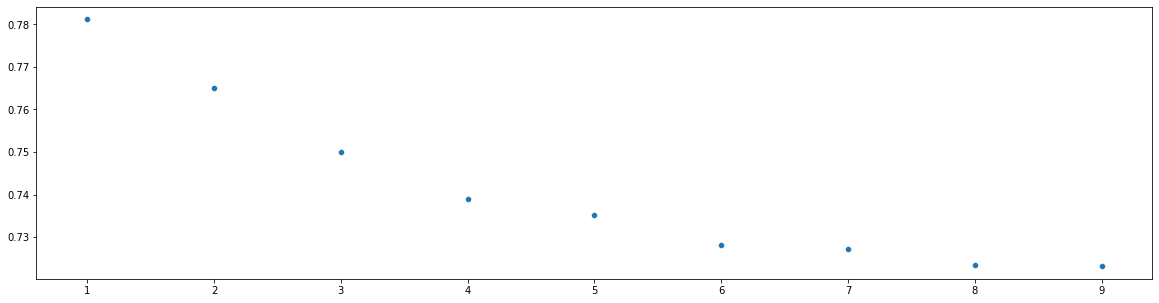

In [ ]:
%%time
plt.figure(figsize=(20, 5))
x, y = [], []
for p in range(1,10):
    x.append(p)
    knn_r = KNeighborsRegressor(n_neighbors=5, p=p)
    y.append(cross_val_score(knn_r, X=check_feature, y=target, cv=kf, scoring="r2").mean())
sns.scatterplot(x=x, y=y)

**Учитываем только параметр усреднения соседей, на основе, которых принимаем решение**

CPU times: user 66.7 ms, sys: 532 µs, total: 67.3 ms
Wall time: 76 ms


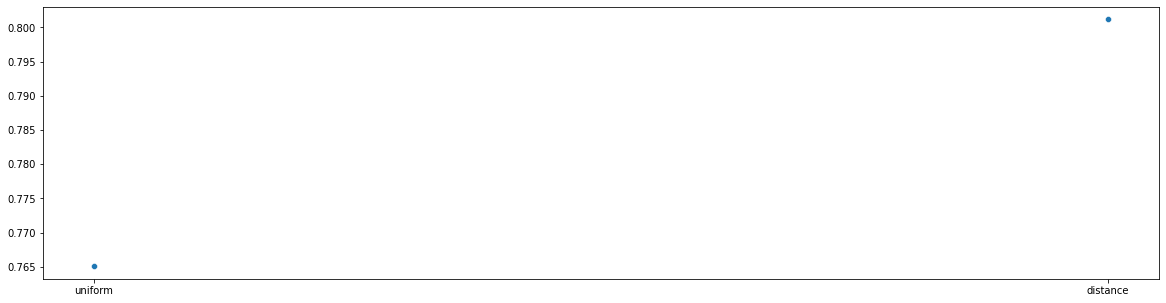

In [ ]:
%%time
plt.figure(figsize=(20, 5))
x, y = [], []
for weights in ['uniform', 'distance']:
    x.append(weights)
    knn_r = KNeighborsRegressor(n_neighbors=5, p=2, weights=weights )
    y.append(cross_val_score(knn_r, X=check_feature, y=target, cv=kf, scoring="r2").mean())
sns.scatterplot(x=x, y=y)

**Решим задачу оптимизации knn полным перебором рассмотренных параметров**

In [ ]:
%%time
weights = ['uniform', 'distance']
p = np.arange(1, 5)
n_neighbors = np.arange(1, 11)
hyperparameters = dict(p=p, n_neighbors=n_neighbors, weights=weights)
knn_r = KNeighborsRegressor(n_jobs=-1)
gridsearch = GridSearchCV(knn_r, hyperparameters, cv=kf, verbose=1, n_jobs=-1)
best_model = gridsearch.fit(check_feature, target)
cross_val_score(best_model, X=check_feature, y=target, cv=kf, scoring="r2").mean()

Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.3s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   22.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   21.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   20.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   20.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   21.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 80 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 388 tasks      | elapsed:   20.3s


CPU times: user 5.38 s, sys: 294 ms, total: 5.68 s
Wall time: 2min 7s


[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   21.0s finished


In [ ]:
best_model.best_params_

{'n_neighbors': 5, 'p': 1, 'weights': 'distance'}

In [ ]:
best_model.best_score_

0.8140326521435833

**Вспомним наши эксперименты с созданием взаимодействующих и нелинейных признаков**

In [ ]:
interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
features_interaction = interaction.fit_transform(check_feature)
non_linear = PolynomialFeatures(degree=3, include_bias=False, interaction_only=False)
features_non_linear = non_linear.fit_transform(check_feature)

In [ ]:
%%time
weights = ['uniform', 'distance']
p = np.arange(1, 5)
n_neighbors = np.arange(1, 11)
hyperparameters = dict(p=p, n_neighbors=n_neighbors, weights=weights)
knn_r = KNeighborsRegressor(n_jobs=-1)
gridsearch = GridSearchCV(knn_r, hyperparameters, cv=kf, verbose=1, n_jobs=-1)
best_model = gridsearch.fit(features_interaction, target)
cross_val_score(best_model, X=features_interaction, y=target, cv=kf, scoring="r2").mean()

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits


0.8004904526060713

In [ ]:
best_model.best_params_

{'n_neighbors': 3, 'p': 2, 'weights': 'distance'}

In [ ]:
%%time
weights = ['uniform', 'distance']
p = np.arange(1, 5)
n_neighbors = np.arange(1, 11)
hyperparameters = dict(p=p, n_neighbors=n_neighbors, weights=weights)
knn_r = KNeighborsRegressor(n_jobs=-1)
gridsearch = GridSearchCV(knn_r, hyperparameters, cv=kf, verbose=1, n_jobs=-1)
best_model = gridsearch.fit(features_non_linear, target)
cross_val_score(best_model, X=features_non_linear, y=target, cv=kf, scoring="r2").mean()

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
CPU times: user 5.4 s, sys: 84 ms, total: 5.49 s
Wall time: 1min 59s


0.7935132430423322

In [ ]:
best_model.best_params_

{'n_neighbors': 3, 'p': 1, 'weights': 'distance'}

## Решаем задачу классификации

**Решение "влоб"**

In [ ]:
knn_clf = KNeighborsClassifier()
model = knn_clf.fit(features, target_2)
cross_val_score(knn_clf, X=features, y=target_2, cv=kf, scoring="f1").mean()

0.7322038905669626

**Стандартизируем признаки**

In [ ]:
knn_clf = KNeighborsClassifier()
model = knn_clf.fit(features_standardized, target_2)
cross_val_score(knn_clf, X=features_standardized, y=target_2, cv=kf, scoring="f1").mean()

0.8286616586593409

**Отбираем значимые признаки и используем для обучения**

In [ ]:
mini_lr = LogisticRegression()
rfe = RFECV(estimator=mini_lr, step=1, cv=5, scoring='f1')
rfe.fit(features, target_2)
print("Optimal number of features : %d" % rfe.n_features_)

rfe_support = rfe.get_support()
check_feature = features[:, rfe_support]
mini_knn = KNeighborsClassifier()
model = mini_knn.fit(check_feature, target_2)
cross_val_score(mini_knn, X=check_feature, y=target_2, cv=kf, scoring="f1").mean()

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


Optimal number of features : 12


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.7543552312219493

**Отбираем лучшие признаки из стандартизированных**

In [ ]:
mini_lr = LogisticRegression()
rfe = RFECV(estimator=mini_lr, step=1, cv=5, scoring='f1', min_features_to_select=3)
rfe.fit(features_standardized, target_2)
print("Optimal number of features : %d" % rfe.n_features_)

rfe_support = rfe.get_support()
print(features_name[rfe_support])
check_feature = features_standardized[:, rfe_support]
mini_knn = KNeighborsClassifier()
model = mini_knn.fit(check_feature, target_2)
cross_val_score(mini_knn, X=check_feature, y=target_2, cv=kf, scoring="f1").mean()

Optimal number of features : 4
['RAD' 'TAX' 'PTRATIO' 'LSTAT']


0.8525429062501566

**Ранее мы обсудили, что есть несколько параметров значимых для ближайших соседей. Давайте посмотрим, как они влияют**

**Учитываем только количество соседей, на основе, которых принимаем решение**

CPU times: user 359 ms, sys: 164 µs, total: 359 ms
Wall time: 360 ms


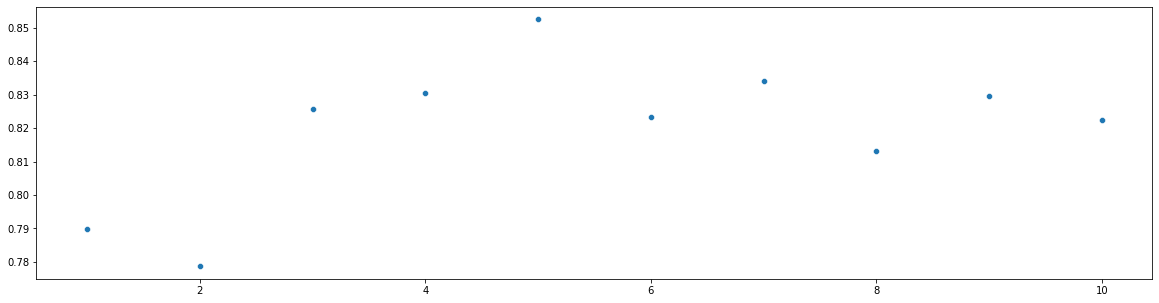

In [ ]:
%%time
plt.figure(figsize=(20, 5))
x, y = [], []
for n_neighbors in range(1,11):
    x.append(n_neighbors)
    knn_r = KNeighborsClassifier(n_neighbors=n_neighbors)
    y.append(cross_val_score(knn_r, X=check_feature, y=target_2, cv=kf, scoring="f1").mean())
sns.scatterplot(x=x, y=y)

**Учитываем только размерность метрики Минковского**

CPU times: user 432 ms, sys: 0 ns, total: 432 ms
Wall time: 438 ms


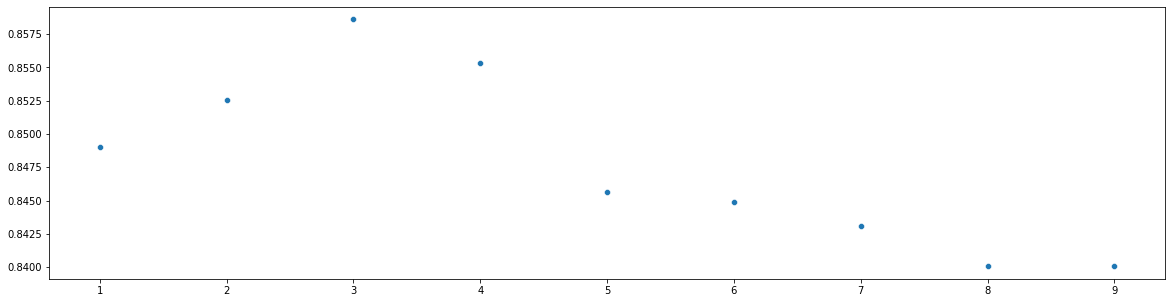

In [ ]:
%%time
plt.figure(figsize=(20, 5))
x, y = [], []
for p in range(1,10):
    x.append(p)
    knn_r = KNeighborsClassifier(n_neighbors=5, p=p)
    y.append(cross_val_score(knn_r, X=check_feature, y=target_2, cv=kf, scoring="f1").mean())
sns.scatterplot(x=x, y=y)

**Учитываем только параметр усреднения соседей, на основе, которых принимаем решение**

CPU times: user 84.2 ms, sys: 1.88 ms, total: 86.1 ms
Wall time: 93.1 ms


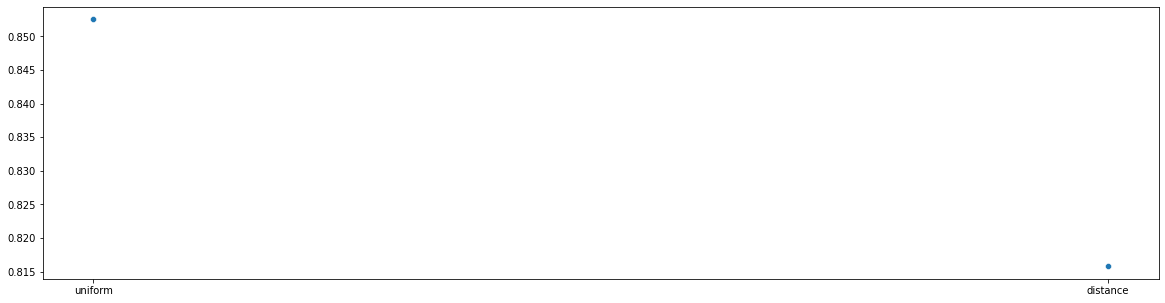

In [ ]:
%%time
plt.figure(figsize=(20, 5))
x, y = [], []
for weights in ['uniform', 'distance']:
    x.append(weights)
    knn_r = KNeighborsClassifier(n_neighbors=5, p=2, weights=weights )
    y.append(cross_val_score(knn_r, X=check_feature, y=target_2, cv=kf, scoring="f1").mean())
sns.scatterplot(x=x, y=y)

**Решим задачу оптимизации knn полным перебором рассмотренных параметров**

In [ ]:
%%time
weights = ['uniform', 'distance']
p = np.arange(1, 5)
n_neighbors = np.arange(1, 11)
hyperparameters = dict(p=p, n_neighbors=n_neighbors, weights=weights)
knn_r = KNeighborsClassifier(n_jobs=-1)
gridsearch = GridSearchCV(knn_r, hyperparameters, cv=kf, verbose=1, n_jobs=-1, scoring="f1")
best_model = gridsearch.fit(check_feature, target_2)
cross_val_score(best_model, X=check_feature, y=target_2, cv=kf, scoring="f1").mean()

CPU times: user 21 µs, sys: 2 µs, total: 23 µs
Wall time: 27.4 µs


In [ ]:
best_model.best_params_

{'n_neighbors': 5, 'p': 3, 'weights': 'uniform'}

**Вспомним наши эксперименты с созданием взаимодействующих и нелинейных признаков**

In [ ]:
interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
features_interaction = interaction.fit_transform(check_feature)
non_linear = PolynomialFeatures(degree=3, include_bias=False, interaction_only=False)
features_non_linear = non_linear.fit_transform(check_feature)

In [ ]:
%%time
knn_r = KNeighborsClassifier(n_jobs=-1)
gridsearch = GridSearchCV(knn_r, hyperparameters, cv=kf, verbose=1, n_jobs=-1, scoring="f1")
best_model = gridsearch.fit(features_interaction, target_2)
cross_val_score(best_model, X=features_interaction, y=target_2, cv=kf, scoring="f1").mean()

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
CPU times: user 5.84 s, sys: 309 ms, total: 6.15 s
Wall time: 2min 10s


In [ ]:
best_model.best_params_

{'n_neighbors': 5, 'p': 3, 'weights': 'uniform'}

In [ ]:
%%time
knn_r = KNeighborsClassifier(n_jobs=-1)
gridsearch = GridSearchCV(knn_r, hyperparameters, cv=kf, verbose=1, n_jobs=-1, scoring="f1")
best_model = gridsearch.fit(features_non_linear, target_2)
cross_val_score(best_model, X=features_non_linear, y=target_2, cv=kf, scoring="f1").mean()

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
Fitting 5 folds for each of 80 candidates, totalling 400 fits
CPU times: user 4.69 s, sys: 76 ms, total: 4.77 s
Wall time: 43.7 s


0.8335468066751204

In [ ]:
best_model.best_params_

{'n_neighbors': 5, 'p': 3, 'weights': 'uniform'}

**Можем подвести итог, что приемы, которые хорошо работали с линейной и логистической регрессией, в алгоритме kNN показываают себя не очень хорошо. НО! В данном алгоритме видим очень большую ВАЖНОСТЬ стандартизации признаков**

**Посмотрим, как поведет себя kNN на задаче мультиклассификации**

In [ ]:
mini_knn = KNeighborsClassifier()
model = mini_knn.fit(check_feature, target_3)
cross_val_score(mini_knn, X=check_feature, y=target_3, cv=kf, scoring="f1_weighted").mean()

0.7531098166415257

# Деревья решений (DecisionTree) <a class="anchor" id="dectree"></a>
[к меню](#content_list)

Деревянные обучающиеся алгоритмы являются широким и популярным семейством родственных непараметрических, контролируемых (с учителем) методов как для классификации, так и для регрессии. Основой для деревянных моделей является дерево принятия решений, в котором серия правил принятия решений (например, "если пол мужской, то...") связаны в цепочку. Результат отдаленно напоминает перевернутое дерево, в котором первое правило принятия решения находится наверху, а последующие правила принятия решений расположены ниже. В дереве принятия решений каждое правило принятия решения выполняется в решающем узле, при этом данное правило создает ветви, ведущие к новым узлам. Ветвь без правила принятия решения в конце называется листом.
Одной из причин популярности древесных моделей является их интерпретируемость. Для создания интуитивно понятной модели деревья принятия решений можно буквально нарисовать в их полной форме (см. рецепт 14.3). От этой базовой
древесной системы отходит целый ряд расширений, начиная со случайных лесов и заканчивая укладкой в ярусы.

Зачастую дерево решений служит обобщением опыта экспертов, средством передачи знаний будущим сотрудникам или моделью бизнес-процесса компании. Например, до внедрения масштабируемых алгоритмов машинного обучения в банковской сфере задача кредитного скоринга решалась экспертами. Решение о выдаче кредита заемщику принималось на основе некоторых интуитивно (или по опыту) выведенных правил, которые можно представить в виде дерева решений.


**Идея деревьев решений:**

Здесь можно вспомнить игру "20 вопросов", которая часто упоминается во введении в деревья решений. Один человек загадывает знаменитость, а второй пытается отгадать, задавая только вопросы, на которые можно ответить "Да" или "Нет" (опустим варианты "не знаю" и "не могу сказать"). Какой вопрос отгадывающий задаст первым делом? Конечно, такой, который сильнее всего уменьшит количество оставшихся вариантов. К примеру, вопрос "Это Анджелина Джоли?" в случае отрицательного ответа оставит более 7 миллиардов вариантов для дальнейшего перебора (конечно, поменьше, не каждый человек – знаменитость, но все равно немало), а вот вопрос "Это женщина?" отсечет уже около половины знаменитостей. То есть, признак "пол" намного лучше разделяет выборку людей, чем признак "это Анджелина Джоли", "национальность-испанец" или "любит футбол". Это интуитивно соответствует понятию прироста информации, основанного на энтропии.

Энтропия Шеннона определяется для системы с возможными состояниями следующим образом:
$$S = -\sum_{i=1}^Np_{i}log_2p_i$$
где pi – вероятности нахождения системы в -ом состоянии. Это очень важное понятие, используемое в физике, теории информации и других областях. Опуская предпосылки введения (комбинаторные и теоретико-информационные) этого понятия, отметим, что, интуитивно, энтропия соответствует степени хаоса в системе. Чем выше энтропия, тем менее упорядочена система и наоборот. Это поможет нам формализовать "эффективное разделение выборки", про которое мы говорили в контексте игры "20 вопросов".

**Пример**

Для иллюстрации того, как энтропия поможет определить хорошие признаки для построения дерева, приведем игрушечный пример. Будем предсказывать цвет шарика по его координате. Конечно, ничего общего с жизнью это не имеет, но позволяет показать, как энтропия используется для построения дерева решений.

<img src=https://hsto.org/files/c96/80a/a4b/c9680aa4babc40f4bbc8b3595e203979.png>

Здесь 9 синих шариков и 11 желтых. Если мы наудачу вытащили шарик, то он с вероятностью **p1 = 9/20** будет синим и с вероятностью **p2 = 11/20** – желтым. Значит, энтропия состояния
$$S_0 = -\frac{9}{20}log_2\frac{9}{20}-\frac{11}{20}log_2\frac{11}{20} \approx 1.$$


Само это значение пока ни о чем нам не говорит. Теперь посмотрим, как изменится энтропия, если разбить шарики на две группы – с координатой меньше либо равной 12 и больше 12.

<img src=https://hsto.org/files/186/444/a8b/186444a8bd0e451c8324ca8529f8d4f4.png>

В левой группе оказалось 13 шаров, из которых 8 синих и 5 желтых. Энтропия этой группы равна
$$S_1 = -\frac{5}{13}log_2\frac{5}{13}-\frac{8}{13}log_2\frac{8}{13} \approx 0.96$$
В правой группе оказалось 7 шаров, из которых 1 синий и 6 желтых. Энтропия правой группы равна
$$S_2 = -\frac{1}{7}log_2\frac{1}{7}-\frac{6}{7}log_2\frac{6}{7} \approx 0.6$$
Как видим, энтропия уменьшилась в обеих группах по сравнению с начальным состоянием, хоть в левой и не сильно. Поскольку энтропия – по сути степень хаоса (или неопределенности) в системе, уменьшение энтропии называют приростом информации. Формально прирост информации (information gain, IG) при разбиении выборки по признаку Q (в нашем примере это признак "x<=12") определяется как 
$$IG(Q) = S_0 - \sum_{i=1}^q\frac{N_i}{N}S_i$$

где:
- q – число групп после разбиения, 
- Ni - число элементов выборки, у которых признак Q имеет i-ое значение.
В нашем случае после разделения получилось две группы (q=2) – одна из 13 элементов (N1=13), вторая – из 7 (N2=7). Прирост информации получился
$$IG(x\leq12) = S_0 - \frac{13}{20}S_1 - \frac{7}{20}S_2 \approx 0.16$$

Получается, разделив шарики на две группы по признаку "координата меньше либо равна 12", мы уже получили более упорядоченную систему, чем в начале. Продолжим деление шариков на группы до тех пор, пока в каждой группе шарики не будут одного цвета.
<img src=https://hsto.org/files/dae/a88/2b0/daea882b0a8e4ef4b23325c88f0353a1.png>

Для правой группы потребовалось всего одно дополнительное разбиение по признаку "координата меньше либо равна 18", для левой – еще три. Очевидно, энтропия группы с шариками одного цвета равна 0
$$log_21 = 0,$$
что соответствует представлению, что группа шариков одного цвета – упорядоченная.

В итоге мы построили дерево решений, предсказывающее цвет шарика по его координате. Отметим, что такое дерево решений может плохо работать для новых объектов (определения цвета новых шариков), поскольку оно идеально подстроилось под обучающую выборку (изначальные 20 шариков). Для классификации новых шариков лучше подойдет дерево с меньшим числом "вопросов", или разделений, пусть даже оно и не идеально разбивает по цветам обучающую выборку. Эту проблему, переобучение, мы еще рассмотрим далее. 

В основе популярных алгоритмов построения дерева решений, таких как ID3 и C4.5, лежит принцип жадной максимизации прироста информации – на каждом шаге выбирается тот признак, при разделении по которому прирост информации оказывается наибольшим. Дальше процедура повторяется рекурсивно, пока энтропия не окажется равной нулю или какой-то малой величине (если дерево не подгоняется идеально под обучающую выборку во избежание переобучения).
В разных алгоритмах применяются разные эвристики для "ранней остановки" или "отсечения", чтобы избежать построения переобученного дерева. 

Следует также отметить, что есть и другая мера разнородности, которая применяется при решении задачи деревьями решений. Это коэффициент разнородности Джини
$$G(t) = 1 - \sum_{i=1}^cp_i^2$$
где
- G(t) - коэффициент разнородности Джини в узле t.
- pi - доля наблюдений класса **с** в узле t
При условии, что в одном листе дерева мы собрали объекты одного класса
$$G(t) = 1 - \sum_{i=1}^c1^2 = 0$$

## Решение задачи регрессии деревьями решений

Регрессионное дерево принятия решений работает аналогично классификационному дереву принятия решений; однако вместо уменьшения коэффициента разнородности Джини или энтропии потенциальные расщепления по умолчанию измеряются по тому, насколько они уменьшают среднюю квадратическую ошибку (MSE):
$$MSE = \frac{1}{n}\sum_{i=1}^n(y_i - \widehat{y_i})^2$$
А предсказание выполняется, как среднее значение всех элементов листа, которые попали туда при обучении. Отсюда вытекает один недостаток регрессионных деревьев - **они не умеют предсказывать значения находящиеся за диапазоном величин, на которых они учились**

In [1]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import RadiusNeighborsClassifier, RadiusNeighborsRegressor
from sklearn.datasets import load_boston

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import  StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Binarizer, KBinsDiscretizer

from sklearn.feature_selection import RFECV
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2 # для выбора категориальных входных признаков
from sklearn.feature_selection import f_regression # числовые признаки и числовой выходной признак
from sklearn.feature_selection import f_classif # числовые входные признаки и категориальный выходной признак

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [2]:
"""Грузим данные"""
boston = load_boston()
features = boston.data
target = boston.target
features_name = boston.feature_names
"""Делаем стандартизированные признаки"""
scaler = StandardScaler()
features_standardized = scaler.fit_transform(features)
"""Создаем таргет для бинарной классификации"""
threshold = (target.max() - target.min())/2
target_2 = Binarizer(threshold=threshold).fit_transform(target.reshape(-1, 1)).flatten()
"""Создаем таргет для мультиклассификации"""
target_3 = KBinsDiscretizer(n_bins=3, encode='ordinal').fit_transform(target.reshape(-1,1)).flatten()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing dataset (i.e.

In [3]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)

**Решение "влоб"**

In [4]:
dt_r = DecisionTreeRegressor(random_state=0)
model = dt_r.fit(features, target)
cross_val_score(dt_r, X=features, y=target, cv=kf, scoring="r2").mean()

0.7402349949422662

**Маленькая особенность решающих деревьев. Они АБСОЛЮТНО переобучаются, если не ограничивать их глубину**

In [5]:
model.score(features, target)

1.0

**Стандартизируем признаки**

In [6]:
dt_r = DecisionTreeRegressor(random_state=0)
model = dt_r.fit(features_standardized, target)
cross_val_score(dt_r, X=features_standardized, y=target, cv=kf, scoring="r2").mean()

0.7413685447544609

**Отбираем значимые признаки и используем для обучения**

In [8]:
mini_dt = DecisionTreeRegressor(random_state=0)
rfe = RFECV(estimator=mini_dt, step=1, cv=5, scoring='r2')
rfe.fit(features, target)
print("Optimal number of features : %d" % rfe.n_features_)

rfe_support = rfe.get_support()
check_feature = features[:, rfe_support]
mini_dt = DecisionTreeRegressor(random_state=0)
model = mini_dt.fit(check_feature, target)
cross_val_score(mini_dt, X=check_feature, y=target, cv=kf, scoring="r2").mean()

Optimal number of features : 13


0.7402349949422662

**Отбираем лучшие признаки из стандартизированных**

In [9]:
mini_dt = DecisionTreeRegressor(random_state=0)
rfe = RFECV(estimator=mini_dt, step=1, cv=5, scoring='r2')
rfe.fit(features_standardized, target)
print("Optimal number of features : %d" % rfe.n_features_)

rfe_support = rfe.get_support()
check_feature = features_standardized[:, rfe_support]
mini_dt = DecisionTreeRegressor(random_state=0)
model = mini_dt.fit(check_feature, target)
cross_val_score(mini_dt, X=check_feature, y=target, cv=kf, scoring="r2").mean()

Optimal number of features : 13


0.7413685447544609

**Посмотрим как влияют на дерево решений разные параметры**

**Учитываем только глубину дерева**

Оптимальная глубина дерева: 6. Достигается точность: 0.7770399415848971
CPU times: user 682 ms, sys: 3.07 ms, total: 685 ms
Wall time: 704 ms


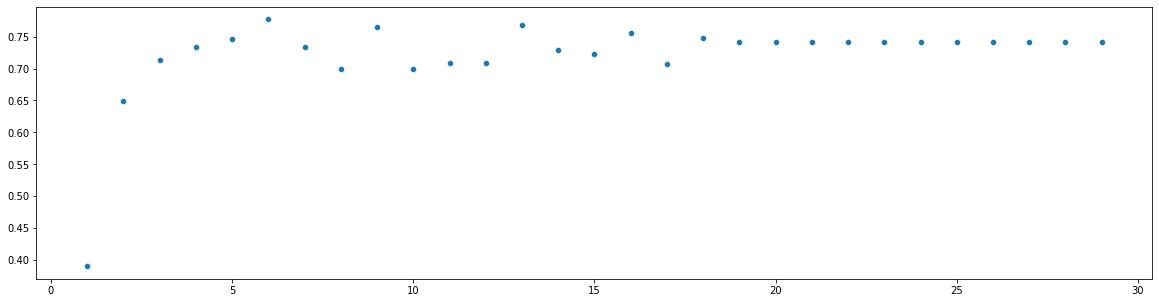

In [10]:
%%time
plt.figure(figsize=(20, 5))
x, y = [], []
for max_depth in range(1,30):
    x.append(max_depth)
    dt_r = DecisionTreeRegressor(max_depth=max_depth, random_state=0)
    y.append(cross_val_score(dt_r, X=check_feature, y=target, cv=kf, scoring="r2").mean())
print(f"Оптимальная глубина дерева: {y.index(max(y)) + 1}. Достигается точность: {y[y.index(max(y))]}")
sns.scatterplot(x=x, y=y)

In [ ]:
# !pip3 install pydotplus
# !pip3 install graphviz

**Посмотрим как выглядят наши деревья**

0.6955744779730269


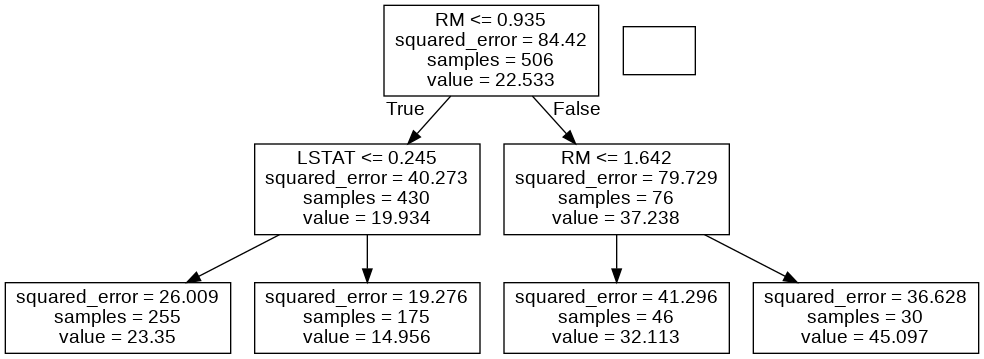

In [11]:
import pydotplus
from sklearn import tree
from IPython.display import Image
dt_r = DecisionTreeRegressor(max_depth=2, random_state=0)
dt_r.fit(check_feature, target)
print(dt_r.score(check_feature, target))
dot_data = tree.export_graphviz(dt_r,
                                out_file=None,
                                feature_names=features_name[rfe_support],
                                class_names=target)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

0.8177924678036443


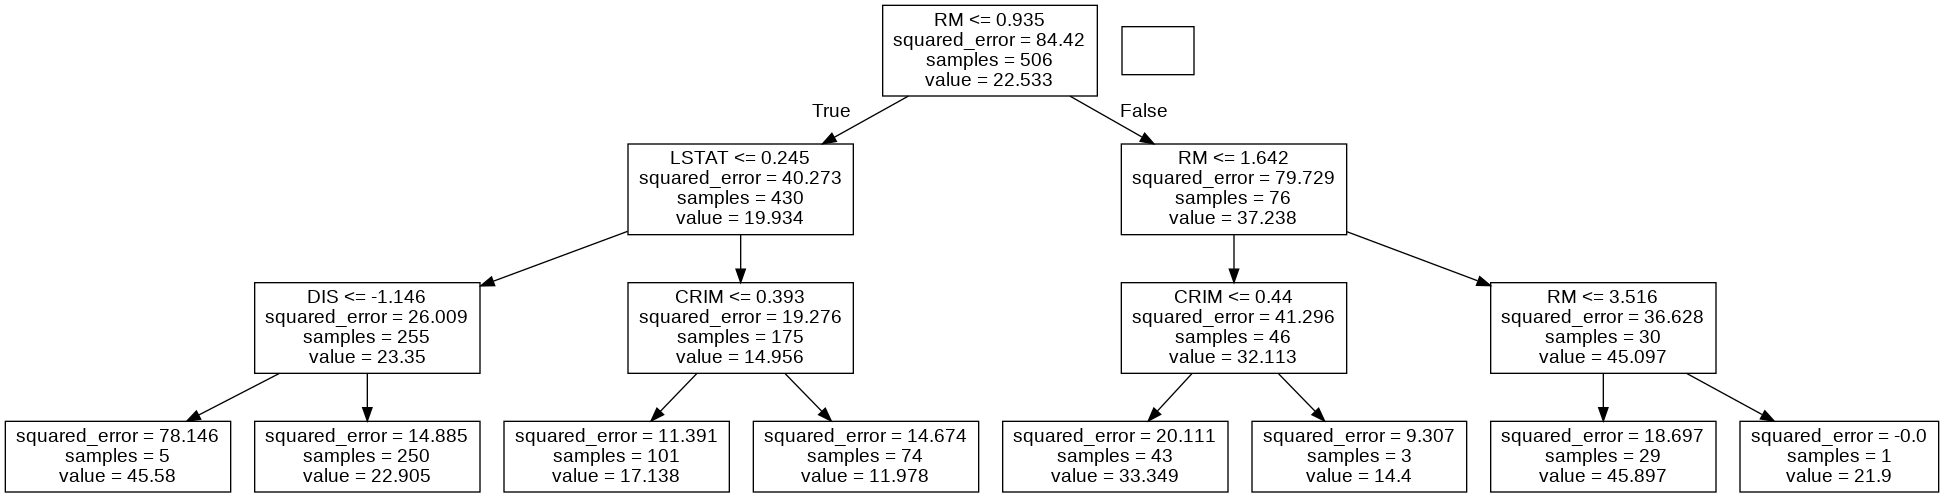

In [12]:
dt_r = DecisionTreeRegressor(max_depth=3, random_state=0)
dt_r.fit(check_feature, target)
print(dt_r.score(check_feature, target))
dot_data = tree.export_graphviz(dt_r,
                                out_file=None,
                                feature_names=features_name[rfe_support],
                                class_names=target)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

0.9449577232928197


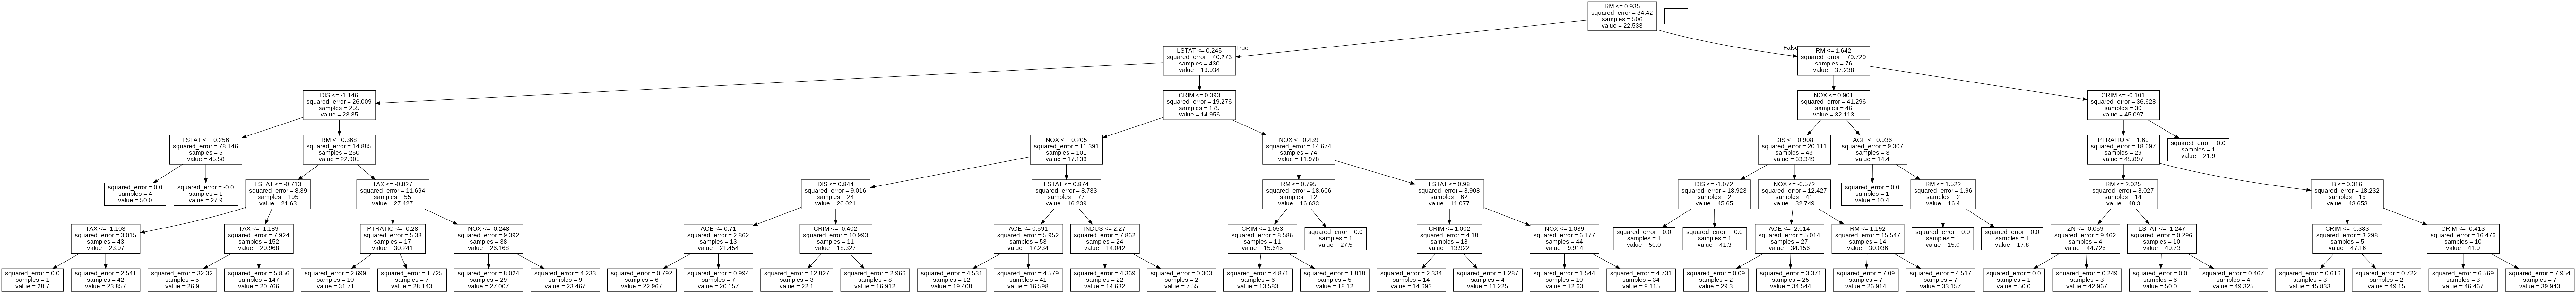

In [13]:
dt_r = DecisionTreeRegressor(max_depth=6, random_state=0)
dt_r.fit(check_feature, target)
print(dt_r.score(check_feature, target))
dot_data = tree.export_graphviz(dt_r,
                                out_file=None,
                                feature_names=features_name[rfe_support],
                                class_names=target)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

Посмотрим на наш случай переобучения в самом начале

In [14]:
dt_r = DecisionTreeRegressor(random_state=0)
dt_r.fit(features, target)
print(dt_r.score(features, target))
dot_data = tree.export_graphviz(dt_r,
                                out_file=None,
                                feature_names=features_name,
                                class_names=target)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

Output hidden; open in https://colab.research.google.com to view.

In [15]:
dt_r.feature_importances_

array([0.03998948, 0.00060121, 0.00409867, 0.00084715, 0.05046496,
       0.57598062, 0.0115331 , 0.07344814, 0.00071385, 0.01265229,
       0.02041985, 0.00596534, 0.20328533])

In [16]:
dt_r.get_depth()

19

**Учитываем только критерий разделения узлов**

/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: 

Оптимальный критерий: 1. Достигается точность: 0.7413685447544609
CPU times: user 339 ms, sys: 3.48 ms, total: 342 ms
Wall time: 343 ms


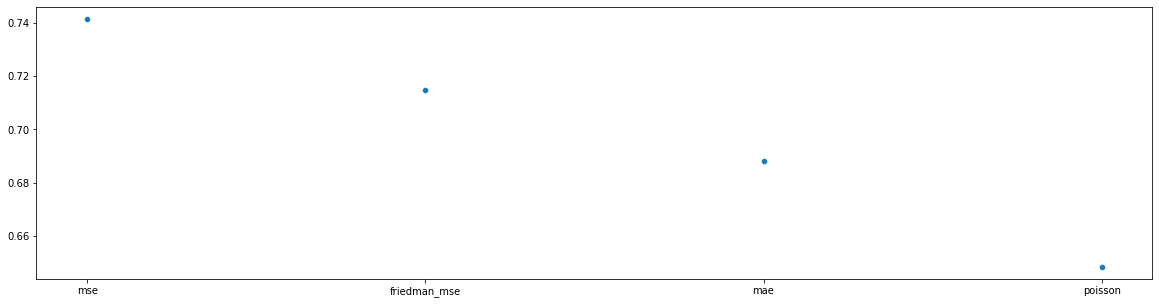

In [17]:
%%time
plt.figure(figsize=(20, 5))
x, y = [], []
for criterion in ["mse", "friedman_mse", "mae", "poisson"]:
    x.append(criterion)
    dt_r = DecisionTreeRegressor(max_depth=None, random_state=0, criterion=criterion)
    y.append(cross_val_score(dt_r, X=check_feature, y=target, cv=kf, scoring="r2").mean())
print(f"Оптимальный критерий: {y.index(max(y)) + 1}. Достигается точность: {y[y.index(max(y))]}")
sns.scatterplot(x=x, y=y)

**Учитываем только параметр "Минимальное количество выборок, необходимое для разделения внутреннего узла"**

Оптимальный критерий: 9. Достигается точность: 0.7647778723820496
CPU times: user 225 ms, sys: 1.72 ms, total: 227 ms
Wall time: 228 ms


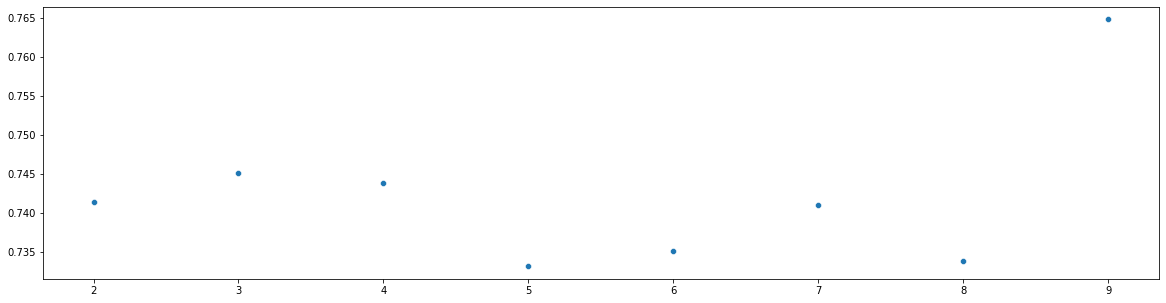

In [18]:
%%time
plt.figure(figsize=(20, 5))
x, y = [], []
for min_samples_split in range(2, 10):
    x.append(min_samples_split)
    dt_r = DecisionTreeRegressor(random_state=0, min_samples_split=min_samples_split)
    y.append(cross_val_score(dt_r, X=check_feature, y=target, cv=kf, scoring="r2").mean())
print(f"Оптимальный критерий: {y.index(max(y)) + 2}. Достигается точность: {y[y.index(max(y))]}")
sns.scatterplot(x=x, y=y)

Минимальное количество выборок, которое требуется для конечного узла. Точка разделения на любой глубине будет учитываться только в том случае, если она оставляет не менее min_samples_leaf обучающих выборок в каждой из левой и правой ветвей. Это может привести к сглаживанию модели, особенно при регрессии

Оптимальный критерий: 3. Достигается точность: 0.7727017103753718
CPU times: user 224 ms, sys: 2.77 ms, total: 227 ms
Wall time: 226 ms


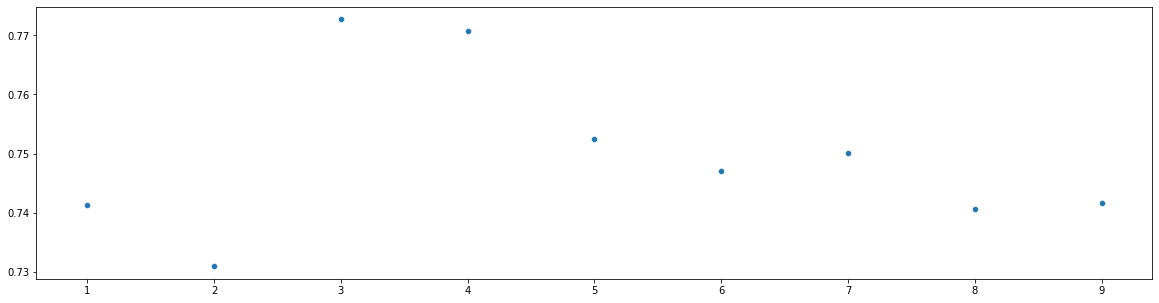

In [19]:
%%time
plt.figure(figsize=(20, 5))
x, y = [], []
for min_samples_leaf in range(1, 10):
    x.append(min_samples_leaf)
    dt_r = DecisionTreeRegressor(random_state=0, min_samples_leaf=min_samples_leaf)
    y.append(cross_val_score(dt_r, X=check_feature, y=target, cv=kf, scoring="r2").mean())
print(f"Оптимальный критерий: {y.index(max(y)) + 1}. Достигается точность: {y[y.index(max(y))]}")
sns.scatterplot(x=x, y=y)

**Решим задачу оптимизации knn полным перебором рассмотренных параметров**

In [22]:
%%time
criterion = ["mse", "friedman_mse"]
max_depth = np.arange(1, 6, 1)
min_samples_leaf = np.arange(1, 6, 1)
min_samples_split = np.arange(2, 11, 1)
hyperparameters = dict(criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
dt_r = DecisionTreeRegressor(random_state=0)
gridsearch = GridSearchCV(dt_r, hyperparameters, cv=kf, verbose=1, n_jobs=-1)
best_model = gridsearch.fit(check_feature, target)
print(cross_val_score(best_model, X=check_feature, y=target, cv=kf, scoring="r2").mean())

Fitting 5 folds for each of 450 candidates, totalling 2250 fits
Fitting 5 folds for each of 450 candidates, totalling 2250 fits
Fitting 5 folds for each of 450 candidates, totalling 2250 fits


/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


Fitting 5 folds for each of 450 candidates, totalling 2250 fits


/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


Fitting 5 folds for each of 450 candidates, totalling 2250 fits


/usr/local/lib/python3.7/dist-packages/sklearn/tree/_classes.py:363: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


Fitting 5 folds for each of 450 candidates, totalling 2250 fits
0.7200366034100502
CPU times: user 11.1 s, sys: 159 ms, total: 11.2 s
Wall time: 29.4 s


In [23]:
best_model.best_params_

{'criterion': 'friedman_mse',
 'max_depth': 4,
 'min_samples_leaf': 1,
 'min_samples_split': 3}

**Вспомним наши эксперименты с созданием взаимодействующих и нелинейных признаков**

In [21]:
interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
features_interaction = interaction.fit_transform(check_feature)
non_linear = PolynomialFeatures(degree=3, include_bias=False, interaction_only=False)
features_non_linear = non_linear.fit_transform(check_feature)

In [ ]:
%%time
criterion = ["mse", "friedman_mse", "mae"]
max_depth = np.arange(1, 11, 2)
min_samples_leaf = np.arange(1, 11, 3)
min_samples_split = np.arange(2, 11, 3)
hyperparameters = dict(criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
dt_r = DecisionTreeRegressor(random_state=0)
gridsearch = GridSearchCV(dt_r, hyperparameters, cv=kf, verbose=1, n_jobs=-1)
best_model = gridsearch.fit(features_interaction, target)
print(cross_val_score(best_model, X=features_interaction, y=target, cv=kf, scoring="r2").mean())

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:   10.4s
[Parallel(n_jobs=-1)]: Done 758 tasks      | elapsed:   58.7s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  1.9min finished


Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 772 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  1.3min finished


Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 772 tasks      | elapsed:   45.1s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  1.3min finished


Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 772 tasks      | elapsed:   45.6s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  1.4min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 772 tasks      | elapsed:   45.3s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  1.3min finished


Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 772 tasks      | elapsed:   45.5s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  1.3min finished


0.6781102643457881
CPU times: user 16.7 s, sys: 1.28 s, total: 18 s
Wall time: 8min 39s


In [ ]:
best_model.best_params_

{'criterion': 'mae',
 'max_depth': 9,
 'min_samples_leaf': 4,
 'min_samples_split': 2}

In [ ]:
%%time
criterion = ["mse", "friedman_mse", "mae"]
max_depth = np.arange(1, 11, 2)
min_samples_leaf = np.arange(1, 11, 3)
min_samples_split = np.arange(2, 11, 3)
hyperparameters = dict(criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
dt_r = DecisionTreeRegressor(random_state=0)
gridsearch = GridSearchCV(dt_r, hyperparameters, cv=kf, verbose=1, n_jobs=-1)
best_model = gridsearch.fit(features_non_linear, target)
print(cross_val_score(best_model, X=features_non_linear, y=target, cv=kf, scoring="r2").mean())

Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 620 tasks      | elapsed:   34.2s
[Parallel(n_jobs=-1)]: Done 870 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  2.8min finished


Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 744 tasks      | elapsed:   56.4s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  2.0min finished


Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 744 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  2.0min finished


Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 744 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  2.0min finished


Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 744 tasks      | elapsed:   57.7s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  2.0min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 180 candidates, totalling 900 fits


[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 744 tasks      | elapsed:   57.1s
[Parallel(n_jobs=-1)]: Done 900 out of 900 | elapsed:  2.0min finished


0.7206002067118534
CPU times: user 17.2 s, sys: 866 ms, total: 18 s
Wall time: 12min 47s


In [ ]:
best_model.best_params_

{'criterion': 'friedman_mse',
 'max_depth': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 5}

## Задача классификации на решающих деревьях

**Решение "влоб"**

In [24]:
dt_clf = DecisionTreeClassifier(random_state=0)
model = dt_clf.fit(features, target_2)
cross_val_score(dt_clf, X=features, y=target_2, cv=kf, scoring="f1").mean()

0.7842945792055056

**Маленькая особенность решающих деревьев. Они АБСОЛЮТНО переобучаются, если не ограничивать их глубину**

In [25]:
model.score(features, target_2)

1.0

**Стандартизируем признаки**

In [26]:
dt_clf = DecisionTreeClassifier(random_state=0)
model = dt_clf.fit(features_standardized, target_2)
cross_val_score(dt_clf, X=features_standardized, y=target_2, cv=kf, scoring="f1").mean()

0.7864072552618436

**Отбираем значимые признаки и используем для обучения**

In [27]:
mini_dt = DecisionTreeClassifier(random_state=0)
rfe = RFECV(estimator=mini_dt, step=1, cv=5, scoring='f1', min_features_to_select=3)
rfe.fit(features, target_2)
print("Optimal number of features : %d" % rfe.n_features_)

rfe_support = rfe.get_support()
check_feature = features[:, rfe_support]
mini_dt = DecisionTreeClassifier(random_state=0)
model = mini_dt.fit(check_feature, target_2)
cross_val_score(mini_dt, X=check_feature, y=target_2, cv=kf, scoring="f1").mean()

Optimal number of features : 4


0.786904495663183

**Отбираем лучшие признаки из стандартизированных**

In [28]:
mini_dt = DecisionTreeClassifier(random_state=0)
rfe = RFECV(estimator=mini_dt, step=1, cv=5, scoring='f1', min_features_to_select=3)
rfe.fit(features_standardized, target_2)
print("Optimal number of features : %d" % rfe.n_features_)

rfe_support = rfe.get_support()
check_feature = features_standardized[:, rfe_support]
mini_dt = DecisionTreeClassifier(random_state=0)
model = mini_dt.fit(check_feature, target_2)
cross_val_score(mini_dt, X=check_feature, y=target_2, cv=kf, scoring="f1").mean()

Optimal number of features : 4


0.786904495663183

**Посмотрим как влияют на дерево решений разные параметры**

**Учитываем только глубину дерева**

Оптимальная глубина дерева: 3. Достигается точность: 0.8233022654718806
CPU times: user 525 ms, sys: 3.58 ms, total: 529 ms
Wall time: 532 ms


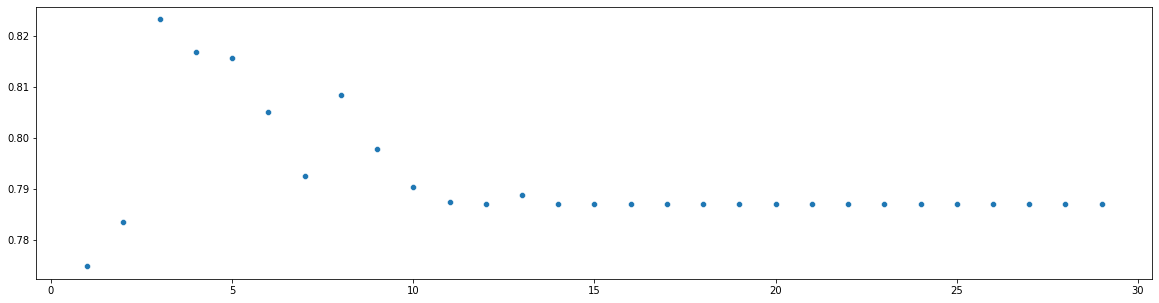

In [29]:
%%time
plt.figure(figsize=(20, 5))
x, y = [], []
for max_depth in range(1,30):
    x.append(max_depth)
    dt_r = DecisionTreeClassifier(max_depth=max_depth, random_state=0)
    y.append(cross_val_score(dt_r, X=check_feature, y=target_2, cv=kf, scoring="f1").mean())
print(f"Оптимальная глубина дерева: {y.index(max(y)) + 1}. Достигается точность: {y[y.index(max(y))]}")
sns.scatterplot(x=x, y=y)

In [ ]:
# !pip3 install pydotplus
# !pip3 install graphviz

**Посмотрим как выглядят наши деревья**

0.8458498023715415


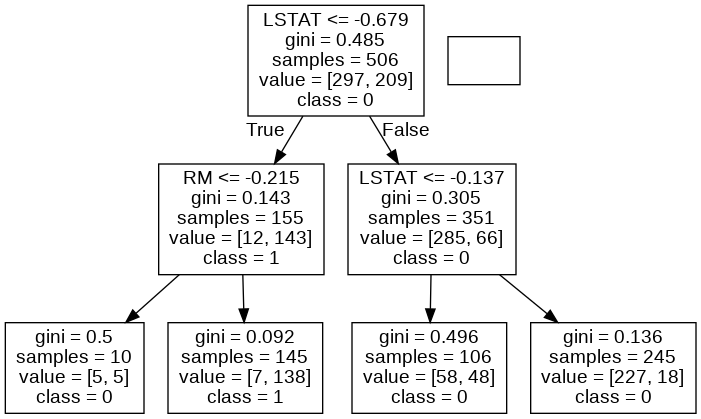

In [30]:
import pydotplus
from sklearn import tree
from IPython.display import Image
dt_r = DecisionTreeClassifier(max_depth=2, random_state=0)
dt_r.fit(check_feature, target_2)
print(dt_r.score(check_feature, target_2))
dot_data = tree.export_graphviz(dt_r,
                                out_file=None,
                                feature_names=features_name[rfe_support],
                                class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

0.8932806324110671


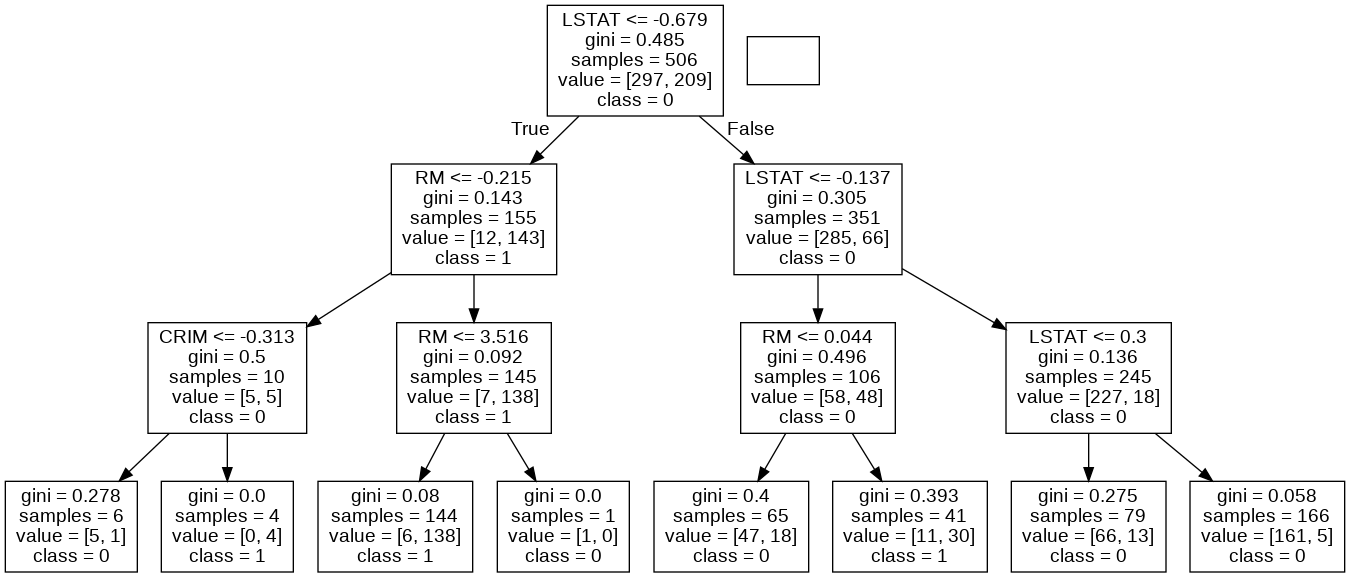

In [31]:
dt_r = DecisionTreeClassifier(max_depth=3, random_state=0)
dt_r.fit(check_feature, target_2)
print(dt_r.score(check_feature, target_2))
dot_data = tree.export_graphviz(dt_r,
                                out_file=None,
                                feature_names=features_name[rfe_support],
                                class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

Посмотрим на наш случай переобучения в самом начале

1.0


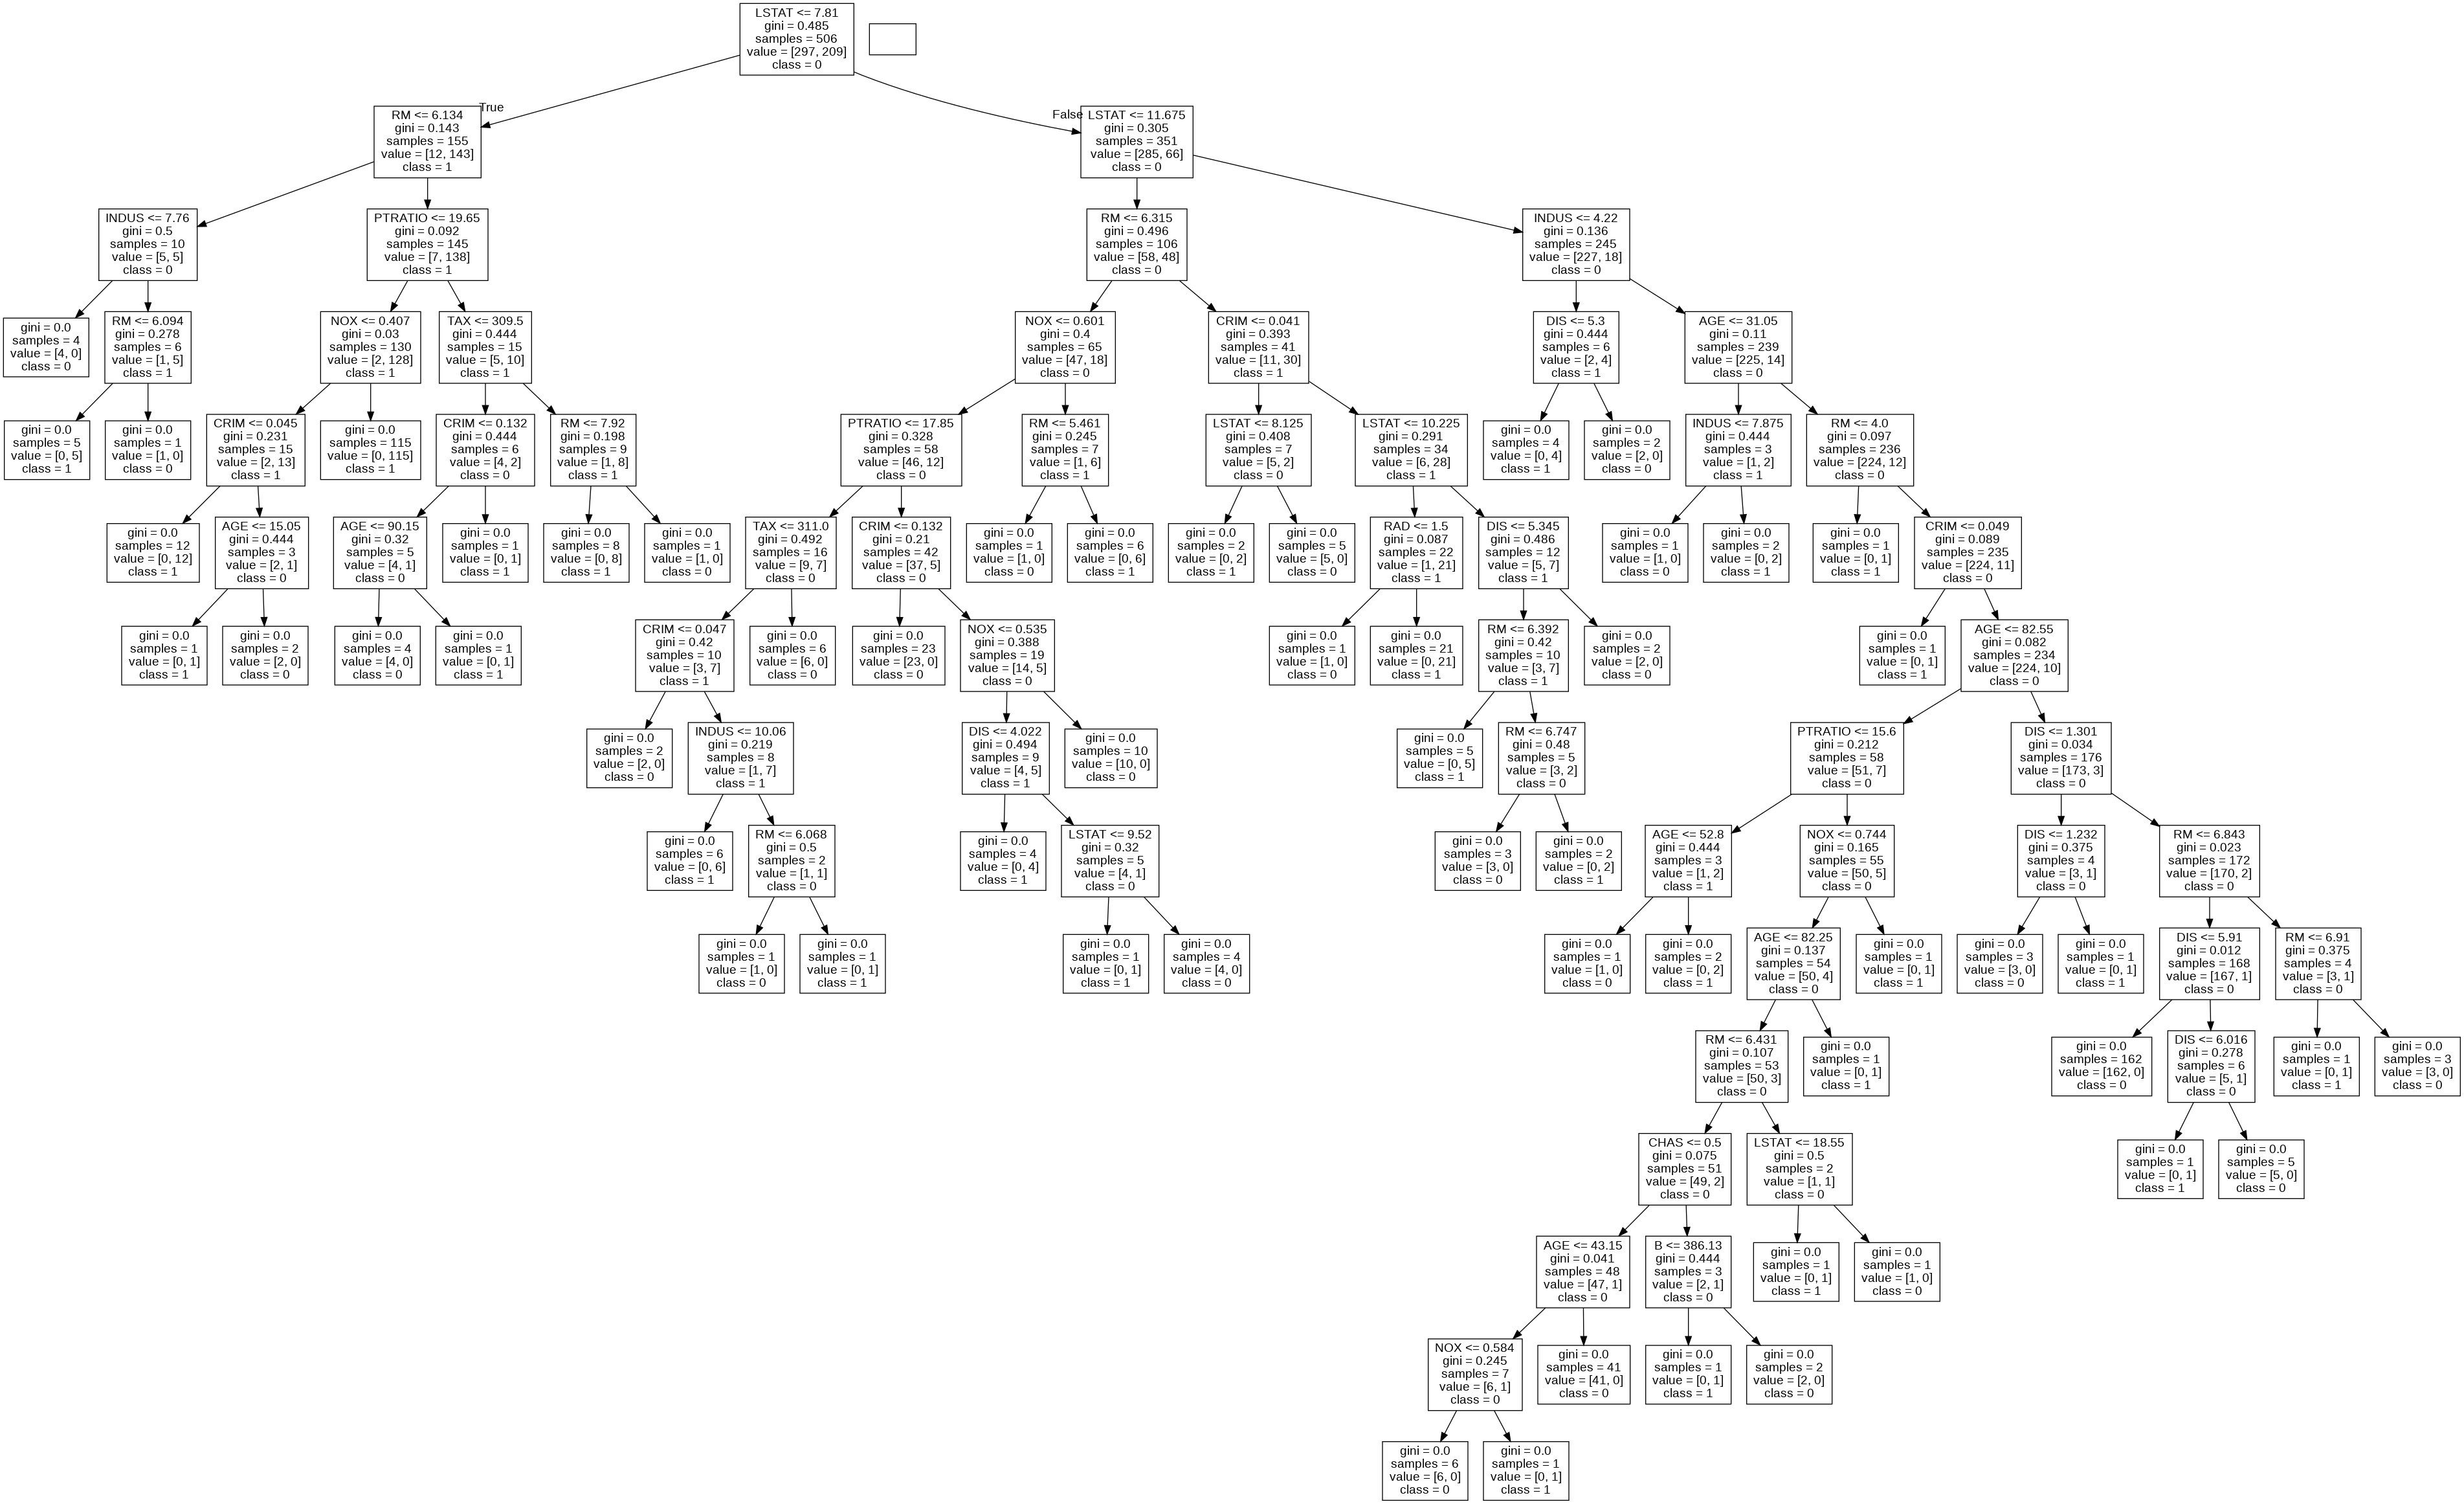

In [32]:
dt_r = DecisionTreeClassifier(random_state=0)
dt_r.fit(features, target_2)
print(dt_r.score(features, target_2))
dot_data = tree.export_graphviz(dt_r,
                                out_file=None,
                                feature_names=features_name,
                                class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

**Учитываем только критерий разделения узлов**

Оптимальный критерий: 2. Достигается точность: 0.8107508017355217
CPU times: user 80.5 ms, sys: 4 ms, total: 84.5 ms
Wall time: 84.8 ms


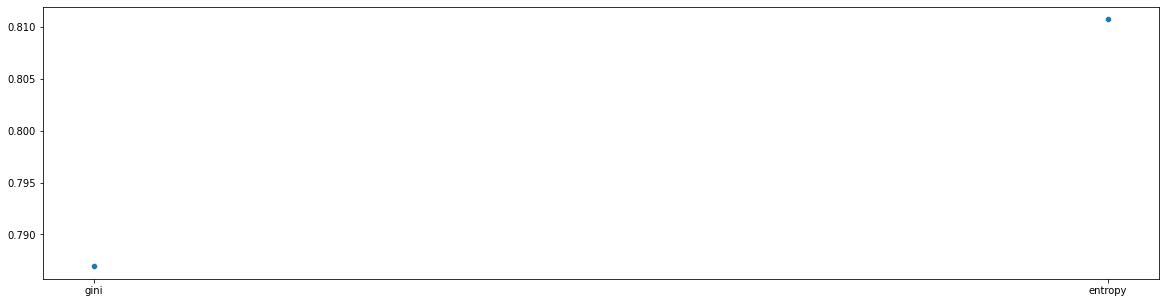

In [33]:
%%time
plt.figure(figsize=(20, 5))
x, y = [], []
for criterion in ["gini", "entropy"]:
    x.append(criterion)
    dt_r = DecisionTreeClassifier(max_depth=None, random_state=0, criterion=criterion)
    y.append(cross_val_score(dt_r, X=check_feature, y=target_2, cv=kf, scoring="f1").mean())
print(f"Оптимальный критерий: {y.index(max(y)) + 1}. Достигается точность: {y[y.index(max(y))]}")
sns.scatterplot(x=x, y=y)

**Учитываем только параметр "Минимальное количество выборок, необходимое для разделения внутреннего узла"**

Оптимальный критерий: 4. Достигается точность: 0.7961540934684221
CPU times: user 194 ms, sys: 4.07 ms, total: 198 ms
Wall time: 192 ms


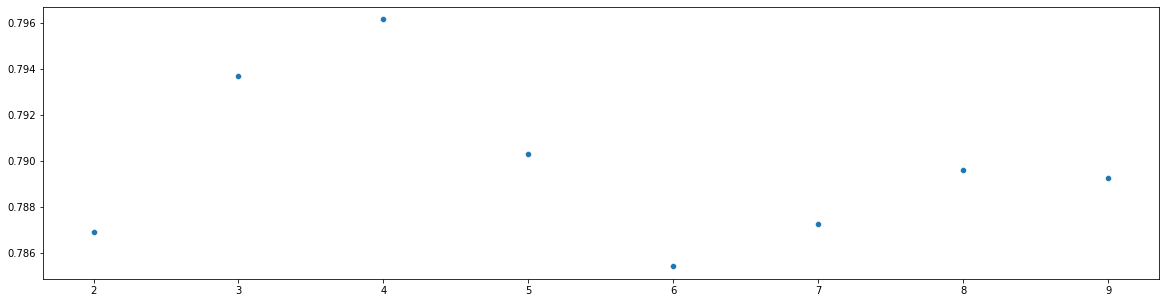

In [34]:
%%time
plt.figure(figsize=(20, 5))
x, y = [], []
for min_samples_split in range(2, 10):
    x.append(min_samples_split)
    dt_r = DecisionTreeClassifier(random_state=0, min_samples_split=min_samples_split)
    y.append(cross_val_score(dt_r, X=check_feature, y=target_2, cv=kf, scoring="f1").mean())
print(f"Оптимальный критерий: {y.index(max(y)) + 2}. Достигается точность: {y[y.index(max(y))]}")
sns.scatterplot(x=x, y=y)

Минимальное количество выборок, которое требуется для конечного узла. Точка разделения на любой глубине будет учитываться только в том случае, если она оставляет не менее min_samples_leaf обучающих выборок в каждой из левой и правой ветвей. Это может привести к сглаживанию модели, особенно при регрессии

Оптимальный критерий: 4. Достигается точность: 0.825188872831208
CPU times: user 190 ms, sys: 806 µs, total: 190 ms
Wall time: 189 ms


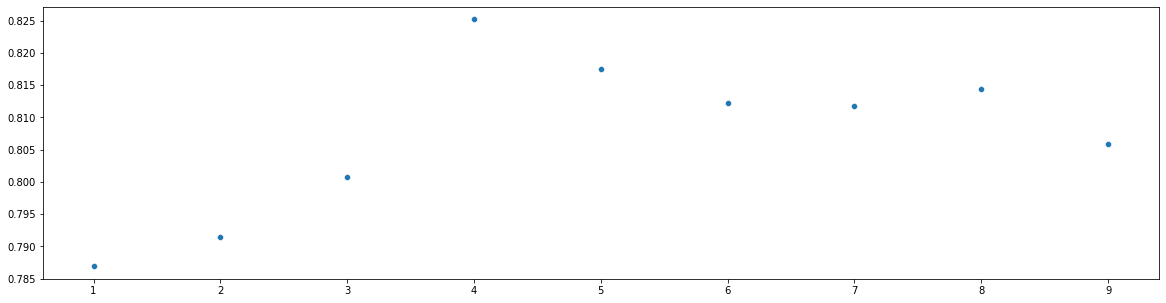

In [35]:
%%time
plt.figure(figsize=(20, 5))
x, y = [], []
for min_samples_leaf in range(1, 10):
    x.append(min_samples_leaf)
    dt_r = DecisionTreeClassifier(random_state=0, min_samples_leaf=min_samples_leaf)
    y.append(cross_val_score(dt_r, X=check_feature, y=target_2, cv=kf, scoring="f1").mean())
print(f"Оптимальный критерий: {y.index(max(y)) + 1}. Достигается точность: {y[y.index(max(y))]}")
sns.scatterplot(x=x, y=y)

**Решим задачу оптимизации knn полным перебором рассмотренных параметров**

In [36]:
%%time
criterion = ["gini", "entropy"]
max_depth = np.arange(1, 5, 1)
min_samples_leaf = np.arange(1, 7, 1)
min_samples_split = np.arange(2, 7, 1)
hyperparameters = dict(criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
dt_r = DecisionTreeClassifier(random_state=0)
gridsearch = GridSearchCV(dt_r, hyperparameters, cv=kf, verbose=1, n_jobs=-1)
best_model = gridsearch.fit(check_feature, target_2)
print(cross_val_score(best_model, X=check_feature, y=target_2, cv=kf, scoring="f1").mean())

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
0.8038002236902786
CPU times: user 6.29 s, sys: 98.8 ms, total: 6.39 s
Wall time: 14.4 s


In [38]:
print(cross_val_score(best_model, X=check_feature, y=target_2, cv=kf, scoring="accuracy").mean())

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
0.8516986992816928


In [37]:
best_model.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

**Вспомним наши эксперименты с созданием взаимодействующих и нелинейных признаков**

In [39]:
interaction = PolynomialFeatures(degree=3, include_bias=False, interaction_only=True)
features_interaction = interaction.fit_transform(check_feature)
non_linear = PolynomialFeatures(degree=3, include_bias=False, interaction_only=False)
features_non_linear = non_linear.fit_transform(check_feature)

In [41]:
%%time
criterion = ["gini", "entropy"]
max_depth = np.arange(1, 6, 1)
min_samples_leaf = np.arange(1, 6, 1)
min_samples_split = np.arange(2, 6, 1)
hyperparameters = dict(criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
dt_r = DecisionTreeClassifier(random_state=0)
gridsearch = GridSearchCV(dt_r, hyperparameters, cv=kf, verbose=1, n_jobs=-1)
best_model = gridsearch.fit(features_interaction, target_2)
print(cross_val_score(best_model, X=features_interaction, y=target_2, cv=kf, scoring="f1").mean())
print(cross_val_score(best_model, X=features_interaction, y=target_2, cv=kf, scoring="accuracy").mean())

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
0.7984706077552971
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
Fitting 5 folds for each of 200 candidates, totalling 1000 fits
0.8438555620267909
CPU times: user 10.1 s, sys: 145 ms, total: 10.2 s
Wall time: 32.9 s


In [42]:
best_model.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'min_samples_leaf': 5,
 'min_samples_split': 2}

In [43]:
%%time
criterion = ["gini", "entropy"]
max_depth = np.arange(1, 7, 1)
min_samples_leaf = np.arange(1, 6, 1)
min_samples_split = np.arange(2, 6, 1)
hyperparameters = dict(criterion=criterion, max_depth=max_depth, min_samples_leaf=min_samples_leaf, min_samples_split=min_samples_split)
dt_r = DecisionTreeClassifier(random_state=0)
gridsearch = GridSearchCV(dt_r, hyperparameters, cv=kf, verbose=1, n_jobs=-1)
best_model = gridsearch.fit(features_non_linear, target_2)
print(cross_val_score(best_model, X=features_non_linear, y=target_2, cv=kf, scoring="f1").mean())

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
0.8063885407797855
CPU times: user 6.69 s, sys: 115 ms, total: 6.81 s
Wall time: 36.5 s


In [44]:
print(cross_val_score(best_model, X=features_non_linear, y=target_2, cv=kf, scoring="accuracy").mean())

Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
Fitting 5 folds for each of 240 candidates, totalling 1200 fits
0.8496990875558144


In [45]:
best_model.best_params_

{'criterion': 'entropy',
 'max_depth': 4,
 'min_samples_leaf': 5,
 'min_samples_split': 2}

# Ансамбли

Хорошим примером ансамблей считается теорема Кондорсе «о жюри присяжных» (1784). Если каждый член жюри присяжных имеет независимое мнение, и если вероятность правильного решения члена жюри больше 0.5, то тогда вероятность правильного решения присяжных в целом возрастает с увеличением количества членов жюри и стремится к единице. Если же вероятность быть правым у каждого из членов жюри меньше 0.5, то вероятность принятия правильного решения присяжными в целом монотонно уменьшается и стремится к нулю с увеличением количества присяжных.

Давайте рассмотрим ещё один пример ансамблей — "Мудрость толпы". Фрэнсис Гальтон в 1906 году посетил рынок, где проводилась некая лотерея для крестьян.
Их собралось около 800 человек, и они пытались угадать вес быка, который стоял перед ними. Бык весил 1198 фунтов. Ни один крестьянин не угадал точный вес быка, но если посчитать среднее от их предсказаний, то получим 1197 фунтов.
Эту идею уменьшения ошибки применили и в машинном обучении.

## Bagging

Bagging (от Bootstrap aggregation) — это один из первых и самых простых видов ансамблей. Он был придуман Ле́о Бре́йманом в 1994 году. Бэггинг основан на статистическом методе бутстрэпа, который позволяет оценивать многие статистики сложных распределений.

### Бутстрэп

Метод бутстрэпа заключается в следующем. Пусть имеется выборка размера **X**. Равномерно возьмем из выборки **N** объектов с возвращением. Это означает, что мы будем **N** раз выбирать произвольный объект выборки (считаем, что каждый объект «достается» с одинаковой вероятностью **1/N**), причем каждый раз мы выбираем из всех исходных **N** объектов. Можно представить себе мешок, из которого достают шарики: выбранный на каком-то шаге шарик возвращается обратно в мешок, и следующий выбор опять делается равновероятно из того же числа шариков. Отметим, что из-за возвращения среди них окажутся повторы. Обозначим новую выборку через **X1**. Повторяя процедуру **M** раз, сгенерируем **M** подвыборок **X1, X2, ..., XM**. Теперь мы имеем достаточно большое число выборок и можем оценивать различные статистики исходного распределения.
<img src="https://hsto.org/getpro/habr/post_images/198/14a/3f7/19814a3f7efaa3b7d1a3f8ab35889832.jpg">

Теперь мы имеем представление о бустрэпе, и мы можем перейти непосредственно к бэггингу. Пусть имеется обучающая выборка X. С помощью бутстрэпа сгенерируем из неё выборки **X1, X2, ..., XM**. Теперь на каждой выборке обучим свой классификатор **ai(x)**. Итоговый классификатор будет усреднять ответы всех этих алгоритмов (в случае классификации это соответствует голосованию):
$$a(x) =  \frac{1}{N}\sum_{i=1}^Ma_i(x) $$
<img src="https://hsto.org/getpro/habr/post_images/d2d/b63/6ff/d2db636ff7c5a59f18858bb93f4323db.png">

В случае регресии имеем:
$$a(x) =  \frac{1}{N}\sum_{i=1}^Mb_i(x) $$
Бэггинг позволяет снизить дисперсию (variance) обучаемого классификатора, уменьшая величину, на сколько ошибка будет отличаться, если обучать модель на разных наборах данных, или другими словами, предотвращает переобучение. Эффективность бэггинга достигается благодаря тому, что базовые алгоритмы, обученные по различным подвыборкам, получаются достаточно различными, и их ошибки взаимно компенсируются при голосовании, а также за счёт того, что объекты-выбросы могут не попадать в некоторые обучающие подвыборки.

## Применение при классификации

In [ ]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neighbors import RadiusNeighborsClassifier, RadiusNeighborsRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

from sklearn.datasets import load_boston

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import  StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Binarizer, KBinsDiscretizer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
"""Грузим данные"""
boston = load_boston()
features = boston.data
target = boston.target
features_name = boston.feature_names
"""Создаем таргет для мультиклассификации"""
target_3 = KBinsDiscretizer(n_bins=3, encode='ordinal').fit_transform(target.reshape(-1,1)).flatten()
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
bag_clf = BaggingClassifier(base_estimator=LogisticRegression(),
                            n_estimators=40,
                            random_state=0,
                            oob_score=True,
                            n_jobs=-1)
model = bag_clf.fit(features, target_3)
cross_val_score(bag_clf, X=features, y=target_3, cv=kf, scoring="accuracy").mean()

0.7252572316055135

In [ ]:
model.oob_score_

0.741106719367589

###Out-of-bag error

При использовании бэгинг моделей нет необходимости в кросс-валидации или в отдельном тестовом наборе, чтобы получить несмещенную оценку ошибки набора тестов. Посмотрим, как получается "внутренняя" оценка модели во время ее обучения.
Каждая модель строится с использованием разных образцов бутстрэпа из исходных данных. Примерно 37% примеров остаются вне выборки бутстрэпа и не используются при построении k-й модели.
Получается, что каждый базовый алгоритм обучается на ~63% исходных объектов. Значит, на оставшихся ~37% его можно сразу проверять. Out-of-Bag оценка — это усредненная оценка базовых алгоритмов на тех ~37% данных, на которых они не обучались. 

In [ ]:
bag_clf = BaggingClassifier(base_estimator=DecisionTreeClassifier(),
                            n_estimators=50,
                            random_state=0,
                            oob_score=True,
                            n_jobs=-1)
model = bag_clf.fit(features, target_3)
cross_val_score(bag_clf, X=features, y=target_3, cv=kf, scoring="accuracy").mean()

0.7964472917880023

In [ ]:
model.oob_score_

0.782608695652174

In [ ]:
rf_clf = RandomForestClassifier(
                                n_estimators=50,
                                random_state=0,
                                oob_score=True,
                                n_jobs=-1)
model = rf_clf.fit(features, target_3)
cross_val_score(rf_clf, X=features, y=target_3, cv=kf, scoring="accuracy").mean()

0.780702776159969

In [ ]:
model.oob_score_

0.7924901185770751

### Задание
Реализовать **свой** RandomForest.
1. Используйте как базовый estimator встроенный DecisionTreeClassifier
2. Не зубудьте, что каждое дерево обучается на выборке. И выборка основана на принципе Bootstrap
3. Для признаков также должна быть случайная выборка, но **без возвратов**, то есть признаки в отличие от наблюдений повторятся не будут.
4. Подумайте оценки в каком виде нужно усреднять, чтобы добиться ожидаемого результата.
5. Обращаю внимание, что для каждого обученного дерева вы должны помнить набор признаков, на котором вы его обучали. Наблюдений я же, напротив, нам помнить не нужно.
6. За эталон возьмите оценку, которую получите с помощью RandomForestClassifier с тем же числом деревьев

### Доп задание, для тех у кого не было numpy
- добавить расчетт oob score
- добавить возможность пробрасывать любую базовую модель (не только дерево)

##Boosting

**AdaBoost как первая реализация**
Сам алгоритм имеет очень наглядную визуальную интерпретацию стоящей за ним интуиции взвешивания наблюдений. Рассмотрим игрушечный пример задачи классификации, в которой мы будем пробовать на каждой итерации Adaboost разделить данные деревом глубины 1 (так называемым "пнем"). На первых двух итерациях мы увидим следующую картинку
<img src="https://hsto.org/web/d28/78f/7ba/d2878f7bad0340fc8002e5ba6d0879a5.jpg">

Размер точки соответствует полученному ей весу за ошибочное предсказание. И мы видим, как на каждой итерации эти веса растут — пни не могут в одиночку справиться с такой задачей. Однако, когда мы произведем взвешенное голосование ранее построенных пней, мы получим искомое нами разделение:
<img src="https://hsto.org/web/b2b/029/d89/b2b029d898f64bbbb158e15d29595969.png">

Но эта первая версия была не очень устойчива к сильным выбросам, а самое главное - она была достаточно **жадной**. Данный алгоритм не пытался оптимизировать исправление ошибки.
По сути:
1. Происходил первый прогноз. Это мог быть прогноз на основе любой **слабой модели** или даже просто случайного распределения.
2. Считалась ошибка предсказания для каждого наблюдения.
3. Обучали следующий алгоритм, который как входные данные X использовал собственно все те же входные данные, а как метки для обучения использовал уже не **y**, а ошибки предсказаний прошлых моделей **y_истинное - y_предсказанное**
4. В конце складываем результаты предсказания всех модделей, каждая из которых, по сути, лишь уточняет предсказание предыдущей, и получаем итоговый результат. Складываем с учетом веса каждого дерева. Вес считается по формуле
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/29c9dabd3c4b0794b8a3de3d2b8fd366585155ff">

In [ ]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.neighbors import RadiusNeighborsClassifier, RadiusNeighborsRegressor
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier

from sklearn.datasets import load_boston

from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import  StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Binarizer, KBinsDiscretizer

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import accuracy_score, f1_score, classification_report

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

In [ ]:
"""Грузим данные"""
boston = load_boston()
features = boston.data
target = boston.target
features_name = boston.feature_names
"""Создаем таргет для мультиклассификации"""
threshold = (target.max() - target.min())/2
target_2 = Binarizer(threshold=threshold).fit_transform(target.reshape(-1, 1)).flatten()
target_3 = KBinsDiscretizer(n_bins=3, encode='ordinal').fit_transform(target.reshape(-1,1)).flatten()
kf = KFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
ada_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                            n_estimators=50,
                            random_state=0,
                            )
model = ada_clf.fit(features, target_3)
cross_val_score(ada_clf, X=features, y=target_3, cv=kf, scoring="accuracy").mean()

0.7410599883517763

In [ ]:
predict = model.predict(features)
np.sum(predict == target_3)/predict.shape

array([0.87549407])

In [ ]:
ada_clf = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=2),
                            n_estimators=50,
                            random_state=0,
                            )
model = ada_clf.fit(features, target_2)
cross_val_score(ada_clf, X=features, y=target_2, cv=kf, scoring="accuracy").mean()

0.8536983110075713

In [ ]:
predict = model.predict(features)
np.sum(predict == target_2)/predict.shape

array([1.])

Еще одна особенность AdaBoost - этот алгоритм ожидает метки не 0 и 1, а -1 и 1

In [ ]:
target_2[target_2==0] = -1
target_2

array([ 1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1.,
       -1., -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  1.,
        1.,  1.,  1.,  1.,  1., -1., -1., -1., -1., -1., -1., -1., -1.,
        1.,  1., -1.,  1.,  1.,  1.,  1., -1., -1., -1., -1.,  1.,  1.,
        1., -1., -1., -1., -1.,  1., -1.,  1.,  1.,  1., -1., -1., -1.,
       -1., -1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1.,
       -1.,  1.,  1., -1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1.,  1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1.,  1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
       -1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
class AdaBoost:

    def __init__(self, M):

        self.M = M # кол-во учеников
    def fit(self, X, Y):

        self.models = [] # список моделей
        self.alphas = [] # список весов для каждой модели
        N, _ = X.shape
        W = np.ones(N) / N # создаем первоначальные веса каждого объекта
        for m in range(self.M):
            tree = DecisionTreeClassifier(max_depth=1) # создаем одну модель
            tree.fit(X, Y, sample_weight=W) # одучаем одну модель с учетом веса наблюдений
            P = tree.predict(X) # делаем предсказания
            err = W.dot(P != Y) # создаем вектор ошибок
            alpha = 0.5*(np.log(1 - err) - np.log(err)) # считаем вес текущей модели
            W = W * np.exp(-alpha*Y*P) # перевзвешиваем веса наблюдений
            W = W / W.sum() # нормализуем веса наблюдений к 1
            self.models.append(tree) # добавляем модель в список
            self.alphas.append(alpha) # добавляем вес текущей модели

    def predict(self, X):

        N, _ = X.shape
        FX = np.zeros(N)
        for alpha, tree in zip(self.alphas, self.models):
            FX += alpha*tree.predict(X)
        FX[FX>=0] = 1
        FX[FX<0] = -1
        return FX

ada_clf = AdaBoost(200)
ada_clf.fit(features, target_2)
predict = ada_clf.predict(features)
accuracy_score(target_2, predict)

0.9387351778656127

### Немного градиентного спуска

Градиентный спуск — метод нахождения локального минимума или максимума функции с помощью движения вдоль градиента.
Представим себе некую функцию зависящую от 2-х параметров
<img src="https://hsto.org/webt/oo/ln/4x/ooln4xwtmg_yie4ikccevpjbpxy.png">

Сверху она будет выглядеть примерно так
<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/7/79/Gradient_descent.png/250px-Gradient_descent.png">

Если ее разрезать плоскостью, то увидим следующее
<img src="https://www.machinelearningmastery.ru/img/0-608727-517151.jpeg">

Теперь введем понятие функции ошибки. В простейшем случае это может быть средний квадрат отклонения MSE, с которым мы уже знакомы.
$$E(w_1,w_2,...w_n)=\frac{1}{m}\sum_{j=1}^{m}\tilde{E}(a_j,y_j)=\frac{1}{m}\sum_{j=1}^{m}(y_j-a_j)^2$$
Будем считать, что предыдущие графики отражают суть данной математической формулы квадратичной функции потерь.

Мы хотим ее минимизировать
$$E(w_1,w_2,...,w_n ) \xrightarrow[]{} min$$

Для этого мы, собственно должны посчитать градиент функции ошибок
$$\bar{V}(w_1,w_2,...,w_n)=(\frac{\mathrm{\partial E} }{\mathrm{\partial w }_1},\frac{\mathrm{\partial E} }{\mathrm{\partial w }_2},...,\frac{\mathrm{\partial E} }{\mathrm{\partial w }_n})$$
Который является вектором, каждый элемент которого - это частная производная всей функции потерь по одному их параметров от которых зависит наша функция потерь.

В случае наших графиков изображенных выше, таких параметров всего два, а значит и длина градиента будет 2.

Теперь опишем процесс применения градиентного спуска в общем виде:
1. Инициализируем первоначальные значения параметров **w**.
2. Считаем на их основе некую функцию, которая выдает предсказания.
3. Считаем ошибку (y - yпред)^2, если она равна 0 или некому заранее заданному малому числу эпсилон, то задача решена. Иначе
4. Считаем градиент
$$\bar{V}(w_1,w_2,...,w_n)=(\frac{\mathrm{\partial E} }{\mathrm{\partial w }_1},\frac{\mathrm{\partial E} }{\mathrm{\partial w }_2},...,\frac{\mathrm{\partial E} }{\mathrm{\partial w }_n})$$
5. Корректируем старые параметры
$$w_i^{k+1}=w_i^k-\Delta w_i=w_i^k-h \frac{\partial E}{\partial w_i}$$
6. Идем на шаг 2 и так пока на 3-ем не остановимся.

### Градиентный бустинг

Теперь применим идею градиента к бустингу

1. Инициализировать начальное приближение параметров. В нашем случае параметрами будут собстввенно предсказания моедли. Для задачи регрессии - это будет просто среднее значение по целевой переменной. Для задачи классификации можно инициализировать изначально все 0 или так называемым "глупым решателем", когда мы имитируем бросание монетки при предсказании класса.
Например у нас есть 5 объектов для предсказания и их метки: [1, 10, 2, 7, 5], то гда их среднее 25/5 = 5. Значит изначально инициализируем вектор первых предсказаний, как predict = [5, 5, 5, 5, 5]
2. Для каждой итерации t = 1, ..., M. Где M - число решателей (число наших базовых деревьев) повторяем следующие шаги

  1. Посчитать градиент функции потерь. В случае решения задачи регрессии и квадратичной функции потерь все сводится просто к рассчету **остатков**. Так как производная (y - yпред)^2 равняется 2*(y - yпред), а с учетом дальнейшего умножения на шаг обучения 2-й мы можем пренебречь и получить просто (y - yпред). То есть на первом шаге нашим "градиентом" будет 
  
  residual = y - predict = [1-5, 10-5, 2-5, 7-5, 5-5] = [-4,, 5, -3, 2, 0]
  2. Обучим дерево на входных X и на полученных ошибках. Сделаем предсказание, сохраним дерево. Теперь у нас есть предсказание ошибки predict_error
  3. Обновим предсказания

  predict = predict + lr * predict_error

3. Сохраняем итоговый predict
4. Используем сохраненный набор деревьев с их шагом обучения для предсказаний

### XGBoost
1. Что если при построении дерева решений будем оптимизировать не стандартную ошибку (MSE или энтропию), а добавим к ним регуляризацию, как в регрессии?
$$\omega(a) = \gamma Z + 0.5\sum_{i=1}^Z\omega_i^2$$
где w - значения в листьях, Z - количество листьев
2. Что если как отдельные решатели в бустинге использовать не отдельные деревья, а бэгинги над этими деревьями?
3. Что если мы видим, что уже несколько шагов бустинга качество не растет? И в такой ситуации будем уменьшать шаг обучения, чтобы снизить вероятность перескочить глобальный минимум функции потерь? А также увеличим глубину следующего дерева, чтобы повысить шанс выявить более сложную зависимость, которую мы очевидно не уловили более простыми деревьями-пнями?

Так мы получим представление о том, как работает XGBoost

1. Подробнее о <a href="https://habr.com/ru/company/ods/blog/327250/">GradientBoosting</a>

2. Подробнее о <a href="https://habr.com/ru/company/mailru/blog/438562/">XGBoost</a>

3. Интересная <a href="https://vas3k.ru/blog/machine_learning/">статья</a> в целом о машинном обучении

 <a class="anchor" id="end"></a>
 [к меню](#content_list)